# Assignment 2

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Keywords**: Transformers, Question Answering, CoQA

## Deadlines

* **December 11**, 2022: deadline for having assignments graded by January 11, 2023
* **January 11**, 2023: deadline for half-point speed bonus per assignment
* **After January 11**, 2023: assignments are still accepted, but there will be no speed bonus

## Overview

### Problem

Question Answering (QA) on [CoQA](https://stanfordnlp.github.io/coqa/) dataset: a conversational QA dataset.

### Task

Given a question $Q$, a text passage $P$, the task is to generate the answer $A$.<br>
$\rightarrow A$ can be: (i) a free-form text or (ii) unanswerable;

**Note**: an question $Q$ can refer to previous dialogue turns. <br>
$\rightarrow$ dialogue history $H$ may be a valuable input to provide the correct answer $A$.

### Models

We are going to experiment with transformer-based models to define the following models:

1.  $A = f_\theta(Q, P)$

2. $A = f_\theta(Q, P, H)$

where $f_\theta$ is the transformer-based model we have to define with $\theta$ parameters.

## The CoQA dataset

<center>
    <img src="https://drive.google.com/uc?export=view&id=16vrgyfoV42Z2AQX0QY7LHTfrgektEKKh" width="750"/>
</center>

For detailed information about the dataset, feel free to check the original [paper](https://arxiv.org/pdf/1808.07042.pdf).



## Rationales

Each QA pair is paired with a rationale $R$: it is a text span extracted from the given text passage $P$. <br>
$\rightarrow$ $R$ is not a requested output, but it can be used as an additional information at training time!

## Dataset Statistics

* **127k** QA pairs.
* **8k** conversations.
* **7** diverse domains: Children's Stories, Literature, Mid/High School Exams, News, Wikipedia, Reddit, Science.
* Average conversation length: **15 turns** (i.e., QA pairs).
* Almost **half** of CoQA questions refer back to **conversational history**.
* Only **train** and **validation** sets are available.

## Dataset snippet

The dataset is stored in JSON format. Each dialogue is represented as follows:

```
{
    "source": "mctest",
    "id": "3dr23u6we5exclen4th8uq9rb42tel",
    "filename": "mc160.test.41",
    "story": "Once upon a time, in a barn near a farm house, there lived a little white kitten named Cotton. 
    Cotton lived high up in a nice warm place above the barn where all of the farmer's horses slept. [...]" % <-- $P$
    "questions": [
        {
            "input_text": "What color was Cotton?",   % <-- $Q_1$
            "turn_id": 1
        },
        {
            "input_text": "Where did she live?",
            "turn_id": 2
        },
        [...]
    ],
    "answers": [
        {
            "span_start": 59,   % <-- $R_1$ start index
            "spand_end": 93,    % <-- $R_1$ end index
            "span_text": "a little white kitten named Cotton",   % <-- $R_1$
            "input_text" "white",   % <-- $A_1$      
            "turn_id": 1
        },
        [...]
    ]
}
```

### Simplifications

Each dialogue also contains an additional field ```additional_answers```. For simplicity, we **ignore** this field and only consider one groundtruth answer $A$ and text rationale $R$.

CoQA only contains 1.3% of unanswerable questions. For simplicity, we **ignore** those QA pairs.

## Dataset Download


In [1]:
%%capture
!pip install transformers
!pip install allennlp_models

In [2]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [3]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')  # <-- Why test? See next slides for an answer!

coqa-train-v1.0.json: 49.0MB [00:08, 5.86MB/s]                            


Download completed!


coqa-dev-v1.0.json: 9.09MB [00:03, 2.85MB/s]                            


Download completed!


## [Task 1] Remove unaswerable QA pairs

Write your own script to remove unaswerable QA pairs from both train and validation sets.

In [4]:
import json
import torch
import pandas as pd
import numpy as np
import sys
import shutil

In [5]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=42)

Now we remove the **unanswerable** QA pairs by accessing both the `train folder` and the `test folder` and checking for **answers** where `input_text` is **unknown**. Additionally, we reindexed the `turn id` such that we don't have discrepancies in the turn number.

In [6]:
dataset_folder = "coqa/"

df = []
deleted_pairs = 0
deleted_files = 0
for split in ["train", "test"]:
  json_file = split + '.json'

  # Read json file
  try:
    with open(os.path.join(dataset_folder, json_file)) as f:
      text = json.load(f)
      f.close()
  except Exception as e:
    print('Failed to process %s. Reason: %s' % (os.path.join(dataset_folder, json_file), e))
    sys.exit(0)
  
  # Collect the data into a DataFrame
  for data in text["data"]:

    dataframe_row = {'source'   : data['source'],
                     'id'       : data['id'],
                     'story'    : data['story'],
                     'questions': [],
                     'answers'  : [],
                     'split'    : split,
                     'QA_length': 0}

    # Delete 'unanswerable' QA pairs
    turn_id = 0
    for idx in range(len(data["answers"])):

      if data["answers"][idx]["input_text"] != "unknown":
        turn_id += 1

        # QUESTION
        dataframe_row['questions'].append(
            {
            'input_text': data['questions'][idx]['input_text'],
            'turn_id'   : turn_id
            })

        # ANSWER + RATIONALE
        dataframe_row['answers'].append(
            {
            'input_text': data['answers'][idx]['input_text'],
            'rationale' : data['answers'][idx]['span_text'],
            'span_start': data['answers'][idx]['span_start'],
            'span_end'  : data['answers'][idx]['span_end'],
            'turn_id'   : turn_id
            })
        
      else:
        deleted_pairs += 1
      
    dataframe_row['QA_length'] = turn_id

    # Delete texts without any valid QA pair
    if turn_id > 0:
      df.append(dataframe_row)
    else:
      deleted_files += 1

df = pd.DataFrame(df)

print(f"Number of deleted QA pairs: {deleted_pairs}")
print(f"Number of deleted files: {deleted_files}")
print()

print(f"Number of remaining QA pairs: {df['QA_length'].sum()}")
print(f"Number of remaining files: {df.shape[0]}")
print(f"Number of unique IDs: {len(df['id'].unique())}")
print()

# All files are unique and contain at least a 'good' QA pair
if df.shape[0] == len(df['id'].unique()) and np.sum(df['QA_length'] == 0) == 0:
  print("All good for now...")

  # ...better to save it!
  dataframe_path = os.path.join(dataset_folder, "dataframe.pkl")
  df.to_pickle(dataframe_path)
else:
  print("Something strange to check!!!")

Number of deleted QA pairs: 1437
Number of deleted files: 6

Number of remaining QA pairs: 115193
Number of remaining files: 7693
Number of unique IDs: 7693

All good for now...


In [7]:
dataframe_path = os.path.join(dataset_folder, "dataframe.pkl")

df = pd.read_pickle(dataframe_path)
df.head()

,source,id,story,questions,answers,split,QA_length
0,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",[{'input_text': 'When was the Vat formally ope...,[{'input_text': 'It was formally established i...,train,19
1,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,"[{'input_text': 'Where was the Auction held?',...","[{'input_text': 'Hard Rock Cafe', 'rationale':...",train,5
2,gutenberg,3bdcf01ogxu7zdn9vlrbf2rqzwplyf,"CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n""...",[{'input_text': 'What did Venters call Lassite...,"[{'input_text': 'gun-man', 'rationale': 'this ...",train,20
3,cnn,3ewijtffvo7wwchw6rtyaf7mfwte0p,(CNN) -- The longest-running holiday special s...,"[{'input_text': 'Who is Rudolph's father?', 't...","[{'input_text': 'Donner', 'rationale': 'Santa'...",train,20
4,gutenberg,3urfvvm165iantk80llvkwwbjs7uzh,CHAPTER XXIV. THE INTERRUPTED MASS \n\nThe mor...,"[{'input_text': 'Who arrived at the church?', ...","[{'input_text': 'the garrison first', 'rationa...",train,10


#### Data Inspection

Spend some time in checking accurately the dataset format and how to retrieve the tasks' inputs and outputs!

In [8]:
print(f"Number of remaining files: {df.shape[0]}")
print(f"How many are the unique stories? {len(df['story'].unique())}")
print()

print("How should we manage these files?")

Number of remaining files: 7693
How many are the unique stories? 7070

How should we manage these files?


Quick check of these duplicated texts...

- Run the following cell and simply look at some of them in the 'duplicates' folder!

-> They contain different Questions and Answers, so we should have no problems in keeping all of them...

In [9]:
# How many files do you want to visualize?
file_limit = 3

if 'duplicates' in os.listdir():
  shutil.rmtree('duplicates')
!mkdir 'duplicates'

count = {}

for story in df['story']:
  if story not in count.keys():
    count[story] = 1
  else:
    count[story] += 1

for story in df['story']:
  if file_limit == 0:
    break

  if story in count.keys():
    if count[story] > 1:
      file_limit -= 1
      indices = np.where(df['story'] == story)[0]

      f = open("duplicates/"+str(indices[0])+'_'+str(len(indices))+".txt", "w")

      f.write(story)
      f.write('\n\n\n')
      for idx in indices:
        for pair in range(df.loc[idx, 'QA_length']):
          f.write(f"Q: {df.loc[idx, 'questions'][pair]['input_text']}\n")
          f.write(f"A: {df.loc[idx, 'answers'][pair]['input_text']}\n")
        f.write('\n')

      f.close()

In [10]:
print(f"Dictionary keys: {list(df.keys())}")

Dictionary keys: ['source', 'id', 'story', 'questions', 'answers', 'split', 'QA_length']


In [11]:
print(df.loc[0, 'story'])

The Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat, is the library of the Holy See, located in Vatican City. Formally established in 1475, although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75,000 codices from throughout history, as well as 1.1 million printed books, which include some 8,500 incunabula. 

The Vatican Library is a research library for history, law, philosophy, science and theology. The Vatican Library is open to anyone who can document their qualifications and research needs. Photocopies for private study of pages from books published between 1801 and 1990 can be requested in person or by mail. 

In March 2014, the Vatican Library began an initial four-year project of digitising its collection of manuscripts, to be made available online. 

The Vatican Secret Archives were separated from the library at the beginning of the 17th

In [12]:
print(f"Questions dictionary keys:  {list(df.loc[0, 'questions'][0].keys())}")
print(f"  Answers dictionary keys:  {list(df.loc[0, 'answers'][0].keys())}")

Questions dictionary keys:  ['input_text', 'turn_id']
  Answers dictionary keys:  ['input_text', 'rationale', 'span_start', 'span_end', 'turn_id']


In [13]:
print("EXAMPLE OF A QUESTION/ANSWER PAIR:\n")
print("Question ->", end=" ")
print(df.loc[0, 'questions'][0])

print("  Answer ->", end=" ")
print(df.loc[0, 'answers'][0])

EXAMPLE OF A QUESTION/ANSWER PAIR:

Question -> {'input_text': 'When was the Vat formally opened?', 'turn_id': 1}
  Answer -> {'input_text': 'It was formally established in 1475', 'rationale': 'Formally established in 1475', 'span_start': 151, 'span_end': 179, 'turn_id': 1}


In [14]:
print("Conversation Structure:\n")
for idx in range(df.loc[0, 'QA_length']):
  question = df.loc[0, 'questions'][idx]
  answer = df.loc[0, 'answers'][idx]

  print(f"Turn {idx+1}")
  print(f"R: {answer['rationale']}")
  print(f"Q: {question['input_text']}")
  print(f"A: {answer['input_text']}")
  print()

Conversation Structure:

Turn 1
R: Formally established in 1475
Q: When was the Vat formally opened?
A: It was formally established in 1475

Turn 2
R: he Vatican Library is a research library
Q: what is the library for?
A: research

Turn 3
R: Vatican Library is a research library for history, law
Q: for what subjects?
A: history, and law

Turn 4
R: Vatican Library is a research library for history, law, philosophy, science and theology
Q: and?
A: philosophy, science and theology

Turn 5
R: March 2014, the Vatican Library began an initial four-year project of digitising its collection of manuscripts
Q: what was started in 2014?
A: a  project

Turn 6
R: Scholars have traditionally divided the history of the library into five period
Q: how do scholars divide the library?
A: into periods

Turn 7
R: Scholars have traditionally divided the history of the library into five periods
Q: how many?
A: five

Turn 8
R: Vatican Apostolic Library (), more commonly called the Vatican Library or simply 

From the conversation above we can think to retrieve the inputs (Q, P) or (Q, P, H) directly from the cells ['story', 'questions' and 'answers'] of the DataFrame.

In [15]:
print("Distribution of splits: ")
print(df['split'].value_counts())
print()

Distribution of splits: 
train    7193
test      500
Name: split, dtype: int64



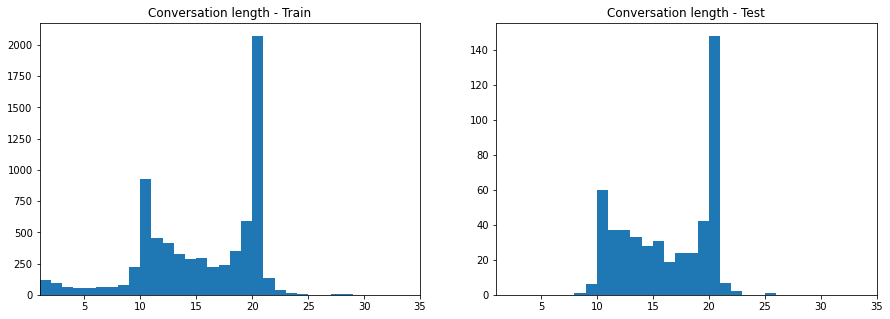

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
train_indices = (df['split'] == 'train')
plt.hist(df.loc[train_indices, 'QA_length'], bins=range(1, 36))
plt.xlim((1, 35))
plt.title("Conversation length - Train")

plt.subplot(1,2,2)
test_indices = (df['split'] == 'test')
plt.hist(df.loc[test_indices, 'QA_length'], bins=range(1, 36))
plt.xlim((1, 35))
plt.title("Conversation length - Test")
plt.show()

## [Task 2] Train, Validation and Test splits

CoQA only provides a train and validation set since the test set is hidden for evaluation purposes.

We'll consider the provided validation set as a test set. <br>
$\rightarrow$ Write your own script to:
* Split the train data in train and validation splits (80% train and 20% val)
* Perform splits such that a dialogue appears in one split only! (i.e., split at dialogue level)
* Perform splitting using the following seed for reproducibility: 42

#### Reproducibility Memo

Check back tutorial 2 on how to fix a specific random seed for reproducibility!

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In the following cell we proceeded to split the `DataFrame` in 3 parts: 

*   Training Set
*   Validation Set
*   Test Set



In [18]:
def split_data(df, seed):
  """
  Inputs:
    - DataFrame
    - seed

  Returns:
    - Train set : DataFrame
    - Val set   : DataFrame
    - Test set  : DataFrame
  """
  df_train, df_val = train_test_split(df[df['split'] == 'train'], train_size=0.8, random_state=seed)
  df_val['split'] = 'val'
  df_test = df[df['split'] == 'test']

  df_train.reset_index(drop=True, inplace=True)
  df_val.reset_index(drop=True, inplace=True)
  df_test.reset_index(drop=True, inplace=True)

  return df_train, df_val, df_test

df_train, df_val, df_test = split_data(df, 42)
print(f"Train files: {df_train.shape[0]}  ({(100 *df_train.shape[0] / df.shape[0]):.1f}%)")
print(f"  Val files: {df_val.shape[0]}  ({(100 *df_val.shape[0] / df.shape[0]):.1f}%)")
print(f" Test files:  {df_test.shape[0]}   ({(100 *df_test.shape[0] / df.shape[0]):.1f}%)")

Train files: 5754  (74.8%)
  Val files: 1439  (18.7%)
 Test files:  500   (6.5%)


Now we preprocessed the data by extracting only the useful information from the `DataFrames` and adding the **history (H)**, to it. 

The **history** can be set to have a fixed length (e.g. hist_length = 3 will take only the 3 previous **QA pairs** as history)

$H = Q_{n-3} + A_{n-3} + Q_{n-2} + A_{n-2} + Q_{n-1} + A_{n-1}$

where `n` indicates the actual turn ($Q_{n}$ is the actual Question).



In [19]:
def preprocess_data(df, hist_length=3):
  """
  Inputs:
    - DataFrame w/o History
    - Length of the History

  Returns:
    - Preprocessed DataFrame with History
  """
  processed_data = []

  for _, row in df.iterrows():
    qa_pairs = list(zip(row['questions'], row['answers']))
    for idx, (question, answer) in enumerate(qa_pairs):
      
      # Create history
      history = ''.join([qa_pairs[i][0]['input_text'] + ' ' + qa_pairs[i][1]['input_text'] + '. ' for i in range(max(0, idx-hist_length), idx)])

      data = {
              'source'    : row['source'],
              'passage'   : row['story'],
              'question'  : question['input_text'],
              'answer'    : answer['input_text'],
              'rationale' : answer['rationale'],
              'span_start': answer['span_start'],
              'span_end'  : answer['span_end'],
              'history'   : history
              }
    
      processed_data.append(data)

  processed_data = shuffle(pd.DataFrame(processed_data), random_state=42)
  processed_data.reset_index(drop=True, inplace=True)
  return processed_data

train_data = preprocess_data(df_train, hist_length=3)
val_data   = preprocess_data(df_val,   hist_length=3)
test_data  = preprocess_data(df_test,  hist_length=3)

In [20]:
train_data.head()

,source,passage,question,answer,rationale,span_start,span_end,history
0,mctest,Mary loved walking through the woods with her ...,Where did they like to hide?,Behind the raspberry bushes.,their secret hiding place behind the raspberry...,445,498,What did they look for together? Blueberries. ...
1,cnn,"(CNN) -- Tragically, another celebrity has die...",which country singer's death is in the headlines?,Mindy McCready,Country singer Mindy McCready's death,136,174,what was Wyatt D.'s cause of death? drug-relat...
2,wikipedia,Vermont () is a state in the New England regio...,Which force represented the New Hampshire colo...,Green Mountain Boys militia,Settlers who held land titles granted by New Y...,1309,1495,During what historic event? Seven Years' War. ...
3,race,"When Charles Stratton was five, he stopped gro...",Who did Tom marry?,Lavinia Warren,"One of the little people was Lavinia Warren, a...",965,1075,What was Charles Stratton's nickname? General ...
4,mctest,The turtle and the fox were best friends. One ...,What did Turtle want to do with him?,go fishing,he wanted to go fishing,636,659,Who was Turtle friends with? fox.


## [Task 3] Model definition

Write your own script to define the following transformer-based models from [huggingface](https://HuggingFace.co/).

* [M1] DistilRoBERTa (distilberta-base)
* [M2] BERTTiny (bert-tiny)

**Note**: Remember to install the ```transformers``` python package!

**Note**: We consider small transformer models for computational reasons!

In [21]:
import transformers
from transformers import AutoTokenizer
from transformers import EncoderDecoderModel, AutoModelForQuestionAnswering

import gc
import warnings
import wandb

from torch.utils.data import Dataset, DataLoader
from allennlp_models.rc.tools import squad

## Models

The models we are going to use are based on two architectures stacked together:


1.   **Span Extractor** (Bert/Roberta for Question-Answering)
2.   **Answer Generator** (Bert/Roberta Encoder-Decoder)

The idea is to use `Span Extractor` to predict the **Rationale** (the sentence where we can find the answer) that will make it easier for the `Answer Generator` to predict the answer.

To do that, we have to pass the **Question & Passage** to the `Span Extractor` so that we get the **Span Start Index & Span End Index**.

Then retrieve the Rationale from the Passage by considering the tokens lying between these indexes. Now we can create the input for the `Answer Generator` that will include both **Question & Rationale**.

<br>

In short:

Question + Passage -> `Span Extractor` -> Rationale -> Question + Rationale -> `Answer Generator` -> Answer

<br>

**THEACHER FORCING**

Since the training of the `Answer Generator` is heavily dependent on the rationale it gets as input, we used a **Teacher Forcing** approach. This means that in the first steps (when the Rationale predicted from the first network is not good) the Encoder-Decoder will use the **ground truth rationale** to predict the answer. The likelihood of this happening decreases linearly as training progresses.

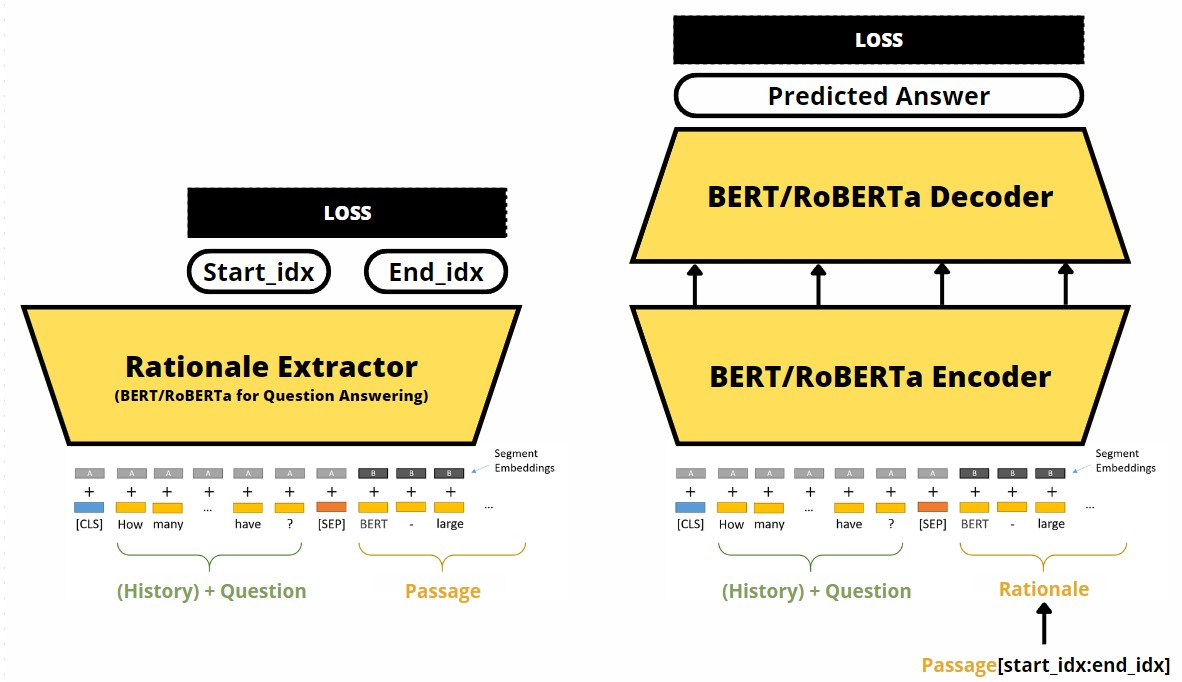

### DistilRoBERTa

Inputs accepted by **RoBERTa** are of the following form (depending on whether we include the history or not):

*   \[CLS] Q \[SEP] \[SEP] P \[SEP] \*\[PAD]
*   \[CLS] Q \[SEP] \[SEP] R \[SEP] \*\[PAD]
*   \[CLS] H + Q \[SEP] \[SEP] P \[SEP] \*\[PAD]
*   \[CLS] H + Q \[SEP] \[SEP] R \[SEP] \*\[PAD]

where H + Q means that the **History ( H )** has been prepended to the current **Question ( Q )**, and the `*` means that the **Padding ( \[PAD] )** may not be present. Usually when the **Padding** is present it includes more than just one token! (e.g. \[CLS] Q \[SEP] \[SEP] P \[SEP] \[PAD] ... \[PAD])

<br>

The most complex part is to re-create the input for the second model. In short:

1.   Get `start_idx/end_idx` predicted by the Span Extractor 
2.   Extract the Rationale which is `Passage[start_idx:end_idx]`
3.   Refine the **Rationale ( R )**, we want to `remove all the special tokens` (i.e. \[SEP] and \[PAD]; \[CLS] tokens can't be present here!)
4.   Compose the new input: \[CLS] Q \[SEP] **\[SEP] R \[SEP] \[PAD]**

**ATTENTION**: Only the part in **bold** of the point **4** is composed by hand. It must be appended to **\[CLS] Q \[SEP]** which is already present in the input of the `Span Extractor`! In the code \[CLS] Q \[SEP] is represented with the variable `quest`.



In [22]:
class M1(torch.nn.Module):
  def __init__(self, name='DistilRoBERTa', finetuned=True, tie_encoder_decoder=False, **kwargs):
    super(M1, self).__init__(**kwargs)
    self.name = name

    # Tokenizer
    self.tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

    # Rationale Extractor
    if finetuned:
        self.span_extractor = AutoModelForQuestionAnswering.from_pretrained("squirro/distilroberta-base-squad_v2")
    else:
        self.span_extractor = AutoModelForQuestionAnswering.from_pretrained("distilroberta-base")
    
    # Answer Generator
    self.answer_generator = EncoderDecoderModel.from_encoder_decoder_pretrained("distilroberta-base", 
                                                                                "distilroberta-base",
                                                                                tie_encoder_decoder=tie_encoder_decoder)
  
    # Set decoder configuration
    self.answer_generator.config.decoder.is_decoder = True
    self.answer_generator.config.decoder.add_cross_attention=True

    # Set model configuration
    self.answer_generator.config.decoder_start_token_id = self.tokenizer.cls_token_id
    self.answer_generator.config.pad_token_id = self.tokenizer.pad_token_id

    # Generation parameters
    self.answer_generator.config.max_length = 64
    self.answer_generator.config.min_length = 2
    self.answer_generator.config.no_repeat_ngram_size = 3
    self.span_extractor.config.finetuning_task = True
    self.answer_generator.config.finetuning_task = True
    self.answer_generator.config.repetition_penalty = 3.0
    self.answer_generator.config.num_beams = 10
    
  def forward(self, inputs, labels, teacher_perc, **kwargs):
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

      sep_token = torch.tensor([self.tokenizer.sep_token_id]).to(device)
      pad_token = torch.tensor([self.tokenizer.pad_token_id]).to(device)
      max_length = torch.tensor(inputs['input_ids'].shape[-1]).to(device)

      ##########################################################################
      ######################### SPAN EXTRACTOR NETWORK #########################
      ##########################################################################

      ############### Predict Rationale from Question + Passage ################
      span_out = self.span_extractor(input_ids=inputs['input_ids'],
                                     attention_mask=inputs['attention_mask'],
                                     start_positions=inputs['start_positions'],
                                     end_positions=inputs['end_positions'])
      
      span_loss = span_out['loss']

      ##########################################################################
      ######################## ENCODER-DECODER NETWORK #########################
      ##########################################################################
      if np.random.rand() < teacher_perc:
          
          ###### Predict Answer from Question + Rationale (GROUND TRUTH) #######
          gen_loss = self.answer_generator(input_ids=inputs['rationale_ids'],
                                           attention_mask=inputs['rationale_attention_mask'],
                                           labels=labels).loss
      
      else:
          ######### Re-create the input for the EncoderDecoder Network #########
          span_start = span_out['start_logits'].argmax(dim=-1)
          span_end = span_out['end_logits'].argmax(dim=-1)

          # Extract the *history + question - [CLS] H + Q [SEP] or [CLS] Q [SEP]
          quest = list(map(lambda x: x[:(x == sep_token).nonzero()[0][0] + 1], inputs['input_ids']))
          
          # Extract the predicted rationale
          rat = list(map(lambda x, q, s, e: 
                          x[len(q)+s:len(q)+e] if len(q) + s < max_length and e > s else
                          x[len(q):],
                          inputs['input_ids'], quest, span_start, span_end))
          
          # Remove 1st [SEP] token if present
          rat = list(map(lambda x: 
                          x[1:] if x[0] == sep_token else   
                          x,                                                                                                                      
                          rat))
        
          # Remove separator and padding tokens from the end
          rat = list(map(lambda x: 
                          x[:(x == sep_token).nonzero()[0][0]] if (sep_token in x) else   # R [SEP] -> R;  R [SEP] [PAD] -> R
                          x,                                                              # R -> R
                          rat))
          
          # Re-create the input - [CLS] Q [SEP] [SEP] R [SEP] *[PAD];  * -> may not be present
          gen_ids = list(map(lambda q, r: 
                             torch.cat((q, sep_token, r[:max_length-len(q)-2], sep_token)).cpu().numpy() if len(r) > max_length - len(q) - 2 else
                             torch.cat((q, sep_token, r, sep_token, torch.tensor([pad_token] * (max_length - len(q) - len(r) - 2)).to(device))).cpu().numpy(),
                             quest, rat))
          
          # Input ids
          gen_ids = np.array(gen_ids, copy=False)
          gen_ids = torch.tensor(gen_ids, dtype=torch.int64).to(device)

          # Attention Mask
          gen_att = torch.tensor(torch.where(gen_ids != pad_token, 1, 0), dtype=torch.int64).to(device)
          
          ######## Predict Answer from Question + Rationale (PREDICTED) ########
          gen_loss = self.answer_generator(input_ids=gen_ids,
                                           attention_mask=gen_att,
                                           labels=labels).loss
      
      return {'loss': gen_loss + span_loss,
              'span_loss': span_loss,
              'gen_loss': gen_loss}
    
  
  def generate(self, inputs, **kwargs):
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

      sep_token = torch.tensor([self.tokenizer.sep_token_id]).to(device)
      pad_token = torch.tensor([self.tokenizer.pad_token_id]).to(device)
      max_length = torch.tensor(inputs['input_ids'].shape[-1]).to(device)

      ##########################################################################
      ######################### SPAN EXTRACTOR NETWORK #########################
      ##########################################################################

      ############### Predict Rationale from Question + Passage ################
      span_out = self.span_extractor(input_ids=inputs['input_ids'],
                                     attention_mask=inputs['attention_mask'])
      
      ##########################################################################
      ######################## ENCODER-DECODER NETWORK #########################
      ##########################################################################
      
      ########### Re-create the input for the EncoderDecoder Network ###########
      span_start = span_out['start_logits'].argmax(dim=-1)
      span_end = span_out['end_logits'].argmax(dim=-1)

      # Extract the *history + question - [CLS] H + Q [SEP] or [CLS] Q [SEP]
      quest = list(map(lambda x: x[:(x == sep_token).nonzero()[0][0] + 1], inputs['input_ids']))
      
      # Extract the predicted rationale
      rat = list(map(lambda x, q, s, e: 
                      x[len(q)+s:len(q)+e] if len(q) + s < max_length and e > s else
                      x[len(q):],
                      inputs['input_ids'], quest, span_start, span_end))
      
      # Remove 1st [SEP] token if present
      rat = list(map(lambda x: 
                      x[1:] if x[0] == sep_token else   
                      x,                                                                                                                      
                      rat))
    
      # Remove separator and padding tokens from the end
      rat = list(map(lambda x: 
                      x[:(x == sep_token).nonzero()[0][0]] if (sep_token in x) else   # R [SEP] -> R;  R [SEP] [PAD] -> R
                      x,                                                              # R -> R
                      rat))
      
      # Re-create the input - [CLS] Q [SEP] [SEP] R [SEP] *[PAD];  * -> may not be present
      gen_ids = list(map(lambda q, r: 
                          torch.cat((q, sep_token, r[:max_length-len(q)-2], sep_token)).cpu().numpy() if len(r) > max_length - len(q) - 2 else
                          torch.cat((q, sep_token, r, sep_token, torch.tensor([pad_token] * (max_length - len(q) - len(r) - 2)).to(device))).cpu().numpy(),
                          quest, rat))
      
      # Input ids
      gen_ids = np.array(gen_ids, copy=False)
      gen_ids = torch.tensor(gen_ids, dtype=torch.int64).to(device)

      # Attention Mask
      gen_att = torch.tensor(torch.where(gen_ids != pad_token, 1, 0), dtype=torch.int64).to(device)

      ################ Predict Answer from Question + Rationale ################
      pred = self.answer_generator.generate(input_ids=gen_ids,
                                            attention_mask=gen_att)
      return pred, gen_ids, (span_start.cpu().tolist(), span_end.cpu().tolist())


### BERTTiny

Inputs accepted by **BERT** are of the following form (depending on whether we include the history or not):

*   \[CLS] Q \[SEP] P \[SEP] \*\[PAD]
*   \[CLS] Q \[SEP] R \[SEP] \*\[PAD]
*   \[CLS] H + Q \[SEP] P \[SEP] \*\[PAD]
*   \[CLS] H + Q \[SEP] R \[SEP] \*\[PAD]

where H + Q means that the **History ( H )** has been prepended to the current **Question ( Q )**, and the `*` means that the **Padding ( [PAD] )** may not be present. Usually when the **Padding** is present it includes more than just one token! (e.g. \[CLS] Q \[SEP] P \[SEP] \[PAD] ... \[PAD])

<br>

The most complex part is to re-create the input for the second model. In short:

1.   Get `start_idx/end_idx` predicted by the Span Extractor 
2.   Extract the Rationale which is `Passage[start_idx:end_idx]`
3.   Refine the **Rationale ( R )**, we want to `remove all the special tokens` (i.e. \[SEP] and \[PAD]; \[CLS] tokens can't be present here!)
4.   Compose the new input: \[CLS] Q \[SEP] **R [SEP] \[PAD]**

**ATTENTION**: Only the part in **bold** of the point **4** is composed by hand. It must be appended to **[CLS] Q [SEP]** which is already present in the input of the `Span Extractor`! In the code [CLS] Q [SEP] is represented with the variable `quest`.

In [23]:
class M2(torch.nn.Module):
  def __init__(self, name='BERTTiny', finetuned=True, tie_encoder_decoder=False, **kwargs):
    super(M2, self).__init__(**kwargs)
    self.name = name

    # Tokenizer
    self.tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

    # Rationale Extractor
    if finetuned:
        self.span_extractor = AutoModelForQuestionAnswering.from_pretrained("mrm8488/bert-tiny-5-finetuned-squadv2")
    else:
        self.span_extractor = AutoModelForQuestionAnswering.from_pretrained("prajjwal1/bert-tiny")

    # Answer Generator
    self.answer_generator = EncoderDecoderModel.from_encoder_decoder_pretrained("prajjwal1/bert-tiny", 
                                                                                "prajjwal1/bert-tiny",
                                                                                tie_encoder_decoder=tie_encoder_decoder)
  
    # Set decoder configuration
    self.answer_generator.config.decoder.is_decoder = True
    self.answer_generator.config.decoder.add_cross_attention=True

    # Set model configuration
    self.answer_generator.config.decoder_start_token_id = self.tokenizer.cls_token_id
    self.answer_generator.config.eos_token_id = self.tokenizer.sep_token_id
    self.answer_generator.config.pad_token_id = self.tokenizer.pad_token_id
    self.answer_generator.config.vocab_size = self.answer_generator.config.decoder.vocab_size

    # Generation parameters
    self.answer_generator.config.max_length = 64
    self.answer_generator.config.min_length = 2
    self.answer_generator.config.no_repeat_ngram_size = 3
    self.span_extractor.config.finetuning_task = True
    self.answer_generator.config.finetuning_task = True
    self.answer_generator.config.repetition_penalty = 3.0
    self.answer_generator.config.num_beams = 10
    
  def forward(self, inputs, labels, teacher_perc, **kwargs):
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

      sep_token = torch.tensor([self.tokenizer.sep_token_id]).to(device)
      pad_token = torch.tensor([self.tokenizer.pad_token_id]).to(device)
      max_length = torch.tensor(inputs['input_ids'].shape[-1]).to(device)

      ##########################################################################
      ######################### SPAN EXTRACTOR NETWORK #########################
      ##########################################################################

      ############### Predict Rationale from Question + Passage ################
      span_out = self.span_extractor(input_ids=inputs['input_ids'],
                                     attention_mask=inputs['attention_mask'],
                                     start_positions=inputs['start_positions'],
                                     end_positions=inputs['end_positions'])
      
      span_loss = span_out['loss']

      ##########################################################################
      ######################## ENCODER-DECODER NETWORK #########################
      ##########################################################################
      if np.random.rand() < teacher_perc:
          
          ###### Predict Answer from Question + Rationale (GROUND TRUTH) #######
          gen_loss = self.answer_generator(input_ids=inputs['rationale_ids'],
                                           attention_mask=inputs['rationale_attention_mask'],
                                           labels=labels).loss
      
      else:
          ######### Re-create the input for the EncoderDecoder Network #########
          span_start = span_out['start_logits'].argmax(dim=-1)
          span_end = span_out['end_logits'].argmax(dim=-1)

          # Extract the *history + question - [CLS] H + Q [SEP] or [CLS] Q [SEP]
          quest = list(map(lambda x: x[:(x == sep_token).nonzero()[0][0] + 1], inputs['input_ids']))
          
          # Extract the predicted rationale
          rat = list(map(lambda x, q, s, e: 
                          x[len(q)+s:len(q)+e] if len(q) + s < max_length and e > s else
                          x[len(q):],
                          inputs['input_ids'], quest, span_start, span_end))
          
          # Remove separation and padding tokens at the end
          rat = list(map(lambda x: 
                          x[:(x == sep_token).nonzero()[0][0]] if sep_token in x else   # R [SEP] -> R;  R [SEP] [PAD] -> R
                          x,                                                            # R -> R
                          rat))
          
          # Re-create the input - [CLS] Q [SEP] R [SEP] *[PAD]; * -> may not be present
          gen_ids = list(map(lambda q, r: 
                             torch.cat((q, r[:max_length-len(q)-1], sep_token)).cpu().numpy() if len(r) > max_length - len(q) - 1 else
                             torch.cat((q, r, sep_token, torch.tensor([pad_token] * (max_length - len(q) - len(r) - 1)).to(device))).cpu().numpy(),
                             quest, rat))
          
          # Input ids
          gen_ids = np.array(gen_ids, copy=False)
          gen_ids = torch.tensor(gen_ids, dtype=torch.int64).to(device)

          # Attention Mask
          gen_att = torch.tensor(torch.where(gen_ids != pad_token, 1, 0), dtype=torch.int64).to(device)
          
          ######## Predict Answer from Question + Rationale (PREDICTED) ########
          gen_loss = self.answer_generator(input_ids=gen_ids,
                                           attention_mask=gen_att,
                                           labels=labels).loss
      
      return {'loss': gen_loss + span_loss,
              'span_loss': span_loss,
              'gen_loss': gen_loss}
    
  
  def generate(self, inputs, **kwargs):
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      
      sep_token = torch.tensor([self.tokenizer.sep_token_id]).to(device)
      pad_token = torch.tensor([self.tokenizer.pad_token_id]).to(device)
      max_length = torch.tensor(inputs['input_ids'].shape[-1]).to(device)

      ##########################################################################
      ######################### SPAN EXTRACTOR NETWORK #########################
      ##########################################################################

      ############### Predict Rationale from Question + Passage ################
      span_out = self.span_extractor(input_ids=inputs['input_ids'],
                                     attention_mask=inputs['attention_mask'])
      
      ##########################################################################
      ######################## ENCODER-DECODER NETWORK #########################
      ##########################################################################
      
      ########### Re-create the input for the EncoderDecoder Network ###########
      span_start = span_out['start_logits'].argmax(dim=-1)
      span_end = span_out['end_logits'].argmax(dim=-1)

      # Extract the *history + question - [CLS] H + Q [SEP] or [CLS] Q [SEP]
      quest = list(map(lambda x: x[:(x == sep_token).nonzero()[0][0] + 1], inputs['input_ids']))
      
      # Extract the predicted rationale
      rat = list(map(lambda x, q, s, e: 
                      x[len(q)+s:len(q)+e] if len(q) + s < max_length and e > s else
                      x[len(q):],
                      inputs['input_ids'], quest, span_start, span_end))
      
      # Remove separation and padding tokens at the end
      rat = list(map(lambda x: 
                      x[:(x == sep_token).nonzero()[0][0]] if sep_token in x else   # R [SEP] -> R;  R [SEP] [PAD] -> R
                      x,                                                            # R -> R
                      rat))
      
      # Re-create the input - [CLS] Q [SEP] R [SEP] *[PAD]; * -> may not be present
      gen_ids = list(map(lambda q, r: 
                          torch.cat((q, r[:max_length-len(q)-1], sep_token)).cpu().numpy() if len(r) > max_length - len(q) - 1 else
                          torch.cat((q, r, sep_token, torch.tensor([pad_token] * (max_length - len(q) - len(r) - 1)).to(device))).cpu().numpy(),
                          quest, rat))
      
      # Input ids
      gen_ids = np.array(gen_ids, copy=False)
      gen_ids = torch.tensor(gen_ids, dtype=torch.int64).to(device)

      # Attention Mask
      gen_att = torch.tensor(torch.where(gen_ids != pad_token, 1, 0), dtype=torch.int64).to(device)

      ################ Predict Answer from Question + Rationale ################
      pred = self.answer_generator.generate(input_ids=gen_ids,
                                            attention_mask=gen_att,
                                            decoder_start_token_id=self.answer_generator.config.decoder.pad_token_id, **kwargs)
      return pred, gen_ids, (span_start.cpu().tolist(), span_end.cpu().tolist())


## Custom Dataset and Training Loop

### Custom Dataset

We customized the `Dataset` class such that we can tokenize tha data we get in a easy and efficient way.

In particular, we created the function `find_indexes` which allows us to compute the position of the **rationale** (start/end token indexes) within the **passage**. In short the function:

1.   Places two `Mask` tokens. One before the first token of the rationale and the other after the last token of the rationale.
2.   Tokenizes the modified passage
3.   Gets the position of the `Mask` tokens (`rat_start/rat_end`)
4.   Corrects these positions depending on whether or not new tokens have been created.

**ATTENTION**: In point **4** new tokens can be created due to the Byte-Pair Encoding (BPE) adopted by RoBERTa tokenizer. This means that when we add the `Mask` tokens the tokenizer can behave differently! (e.g. It can change the tokens before and after the mask because the byte pairs may have changed)



In [24]:
def find_indexes(tokenizer, passage, start_idx, end_idx, encoder_max_len, model_name):
    """
    Inputs:
      - Passage
      - Position of the first character of the Rationale
      - Position of the last character of the Rationale
      - Model name

    Returns:
      - Position of the first token of the Rationale
      - Position of the last token of the Rationale
    """

    # Surround Rationale with [SEP] tokens ->  ...[SEP]Rationale[SEP]...
    passage_ext = passage[:start_idx] + tokenizer.sep_token + passage[start_idx:end_idx] + tokenizer.sep_token + passage[end_idx:]
    passage_tokens = np.array(tokenizer(passage_ext).input_ids)

    rat_start = np.where(passage_tokens == tokenizer.sep_token_id)[0][0]    # 1st [SEP] (rationale start)
    rat_end = np.where(passage_tokens == tokenizer.sep_token_id)[0][1] - 1  # 2nd [SEP] (rationale end)

    left_tokens = len(tokenizer(passage[:end_idx]).input_ids[:-1]) 
    right_tokens = len(tokenizer(passage[start_idx:]).input_ids[1:])
    tot_tokens = len(tokenizer(passage_ext).input_ids)

    left_correct = rat_end - left_tokens
    right_correct = tot_tokens - rat_start - 2 - right_tokens - left_correct

    if model_name == 'BERTTiny': # BERT-Tiny introduces one less token wrt RoBERTa 
        rat_start -= 1
        rat_end -= 1
    return max(0, rat_start - left_correct), min(encoder_max_len-1, rat_end + right_correct)

In [25]:
class TokenizedDataset(Dataset):
    
    def __init__(self, df, model, history=False, encoder_max_len=512, decoder_max_len=32):
        super(TokenizedDataset).__init__()
        self.df = df
        self.name = model.name
        self.tokenizer = model.tokenizer 
        self.history = history
        self.encoder_max_len = encoder_max_len
        self.decoder_max_len = decoder_max_len
        
    def __len__(self):
        return len(self.df) 
    
    def __getitem__(self, idx):
        
        row  = self.df.iloc[idx]
        passage = row.passage
        history = row.history
        question = row.question   
        answer = row.answer
        rationale = row.rationale
        start_idx = row.span_start
        end_idx = row.span_end

        span_start, span_end = find_indexes(self.tokenizer, passage, start_idx, end_idx, self.encoder_max_len, self.name)

        if self.history is False:
          # INPUT:  [CLS] QUESTION [SEP] PASSAGE [SEP] *[PAD]
          input_encoding = self.tokenizer(
              question, 
              passage, 
              padding='max_length',
              truncation=True,
              max_length=self.encoder_max_len, 
          )
          rationale_encoding = self.tokenizer(
              question, 
              rationale, 
              padding='max_length',
              truncation=True,
              max_length=self.encoder_max_len, 
          )          
        else:
          # INPUT:  [CLS] HISTORY + QUESTION [SEP] PASSAGE [SEP] *[PAD]
          input_encoding = self.tokenizer(
              history + question, 
              passage, 
              padding='max_length',
              truncation=True,
              max_length=self.encoder_max_len, 
          )
          rationale_encoding = self.tokenizer(
              history + question, 
              rationale, 
              padding='max_length',
              truncation=True,
              max_length=self.encoder_max_len, 
          )

        # OUTPUT: [CLS] ANSWER [SEP] *[PAD]
        output_encoding = self.tokenizer(
            answer, truncation=True, padding='max_length', max_length=self.decoder_max_len 
        )
                      
        labels = output_encoding.input_ids
        
        # Ignore the loss of the [PAD] labels by setting them to -100
        labels = [-100 if token == self.tokenizer.pad_token_id else token for token in labels]
        labels = torch.tensor(labels, dtype=torch.int64)
          
        inputs = {
            'input_ids': torch.tensor(input_encoding.input_ids, dtype=torch.int64),
            'attention_mask': torch.tensor(input_encoding.attention_mask, dtype=torch.int64),

            'rationale_ids': torch.tensor(rationale_encoding.input_ids, dtype=torch.int64),
            'rationale_attention_mask': torch.tensor(rationale_encoding.attention_mask, dtype=torch.int64),

            'start_positions': torch.tensor(span_start, dtype=torch.int64),
            'end_positions': torch.tensor(span_end, dtype=torch.int64)
        }
          
        return inputs, labels

### Training Loop

In the training loop we simply train the model according to the selected parameters. 

In [26]:
def train(model,
          train_dataset, 
          val_dataset,
          batch_size=32, 
          gradient_accumulation=1,
          epochs=3, 
          lr=5e-5,
          teacher_start=1, 
          teacher_end=0.1, 
          save_path=None,
          monitor=True):

      # Prepare DataLoaders
      train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True, num_workers=2, pin_memory=True)
      val_loader   = DataLoader(val_dataset,   batch_size=batch_size, drop_last=False, shuffle=True, num_workers=2, pin_memory=True)

      # Check for GPU
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      model.to(device)

      if monitor:
          # Connect Wandb
          wandb.login()
          wandb.init(project='NLP')
          wandb.config = {"learning_rate": lr, "epochs": epochs}
          wandb.watch(model)
          print('\n')

      # Optimizer
      optimizer = transformers.AdamW(model.parameters(), lr=lr, weight_decay=0.01, correct_bias=True, no_deprecation_warning=True)

      # Teacher Forcing Decay Schedule
      decay_steps = len(train_loader.dataset) * epochs
      decay_rate = teacher_end / teacher_start

      train_loss = []; val_loss = []; tot_steps = 0
      loss_avg = 0.0; span_loss_avg = 0.0; gen_loss_avg = 0.0

      for epoch in range(epochs):

          # TRAINING LOOP
          train_loop = tqdm(train_loader, leave=False, miniters=int(50), maxinterval=60)

          model.train()
          epoch_train_loss = 0.0
          optimizer.zero_grad()
          for idx, (inputs, labels) in enumerate(train_loop):
              
              # Teacher Forcing Linear Decay 
              teacher_perc = teacher_end + (teacher_start - teacher_end) * (1 - tot_steps / decay_steps)

              inputs = {k: v.to(device) for k, v in inputs.items()}
              labels = labels.to(device)
                    
              # Forward pass
              outputs = model(inputs, labels=labels, teacher_perc=teacher_perc)
              loss = outputs['loss'] / gradient_accumulation

              # Accumulate loss
              epoch_train_loss += float(outputs['loss'])
              tot_steps += labels.shape[0]
              
              if monitor:
                  # Loss Exponential Moving Average
                  loss_avg = float(outputs['loss']) * (2 / (512/batch_size+1)) + loss_avg * (1 - (2 / (512/batch_size+1)))
                  span_loss_avg = float(outputs['span_loss']) * (2 / (512/batch_size+1)) + span_loss_avg * (1 - (2 / (512/batch_size+1)))
                  gen_loss_avg = float(outputs['gen_loss']) * (2 / (512/batch_size+1)) + gen_loss_avg * (1 - (2 / (512/batch_size+1)))

              # Backward pass
              loss.backward()
              if ((idx + 1) % gradient_accumulation == 0) or (idx + 1 == len(train_loader)):
                  optimizer.step()
                  optimizer.zero_grad()
              
                  if monitor and idx > 1024/batch_size:
                      wandb.log({"loss": loss_avg,
                                "span_loss": span_loss_avg,
                                "gen_loss": gen_loss_avg,
                                "teacher_perc": teacher_perc}, step=tot_steps)
              
              gc.collect()
              
          avg_loss = epoch_train_loss / len(train_loader)
          train_loss.append(avg_loss)

          # VALIDATION LOOP
          val_loop = tqdm(val_loader, leave=False, miniters=int(50), maxinterval=60)

          model.eval()
          epoch_val_loss = 0
          with torch.no_grad():
              for inputs, labels in val_loop:
                  
                  inputs = {k: v.to(device) for k, v in inputs.items()}
                  labels = labels.to(device)

                  # Forward pass
                  outputs = model.forward(inputs, labels=labels, teacher_perc=0)
                  loss = outputs["loss"]

                  # Accumulate loss
                  epoch_val_loss += loss

          avg_val_loss = epoch_val_loss / len(val_loader)
          val_loss.append(avg_val_loss)

          if monitor:
              wandb.log({"val_loss": avg_val_loss}, step=tot_steps)

          print(f'\nEpoch = {epoch}: train_loss = {avg_loss:.4f}; val_loss = {avg_val_loss:.4f}\n')

      # Save model weight for inference
      if save_path is not None:
          torch.save(model, save_path)

          del model
          print("The model has been saved!")
      else:
          print("The training is finished!")


def train_model(model, df, params):
    """
    Inputs:
      - Model to train
      - Training Parameters

    Return:
      - Path of the saved model
    """
    warnings.filterwarnings('ignore')
    seed = params['seed']
    fix_random(seed=seed)

    # Split DataFrame
    df_train, df_val, _ = split_data(df, seed=seed)

    # Compute History
    train_data = preprocess_data(df_train, hist_length=params['history_length'])
    val_data   = preprocess_data(df_val,   hist_length=params['history_length'])

    # Tokenize Data
    train_dataset = TokenizedDataset(train_data, model, history=params['history'])
    val_dataset   = TokenizedDataset(val_data,   model, history=params['history'])

    if params['history']:
      save_path = model.name + f'-{params["history_length"]}-history-checkpoint'
    else:
      save_path = model.name + '-checkpoint'

    # Train
    train(model, 
          train_dataset, 
          val_dataset, 
          batch_size=params['batch_size'],
          gradient_accumulation=params['gradient_accumulation'],
          epochs=params['epochs'],
          lr=params['lr'],
          teacher_start=params['teacher_start'], 
          teacher_end=params['teacher_end'],
          save_path=save_path,
          monitor=params['monitor'])
    
    return save_path

In [27]:
def predict(model, test_loader, **kwargs):
    """
    Inputs:
      - Model
      - Test Loader

    Return:
      - Predicted Answers    : List
      - Predicted Rationales : List
    """
    
    # Check for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    test_loop = tqdm(test_loader, leave=False)
    pred = []; pred_rat = []
    model.eval()
    with torch.no_grad():
      for inputs, labels in test_loop:

          inputs = {k: v.to(device) for k, v in inputs.items()}
          labels = torch.tensor([[model.tokenizer.pad_token_id if token == -100 else token for token in label] for label in labels], dtype=torch.int64)
          labels = labels.to(device)
         
          # Forward pass
          outputs, gen_ids, _ = model.generate(inputs, **kwargs)

          for idx in range(gen_ids.shape[0]):
              start_rat = (gen_ids[idx] == model.tokenizer.sep_token_id).nonzero()[0][0] + 1
              gen_id = gen_ids[idx][start_rat:]
              pred_rat.append(model.tokenizer.decode(gen_id, skip_special_tokens=True))
              
          pred.extend(model.tokenizer.batch_decode(outputs, skip_special_tokens=True))
    return pred, pred_rat


def evaluate_model(model, df, params):
    """
    Inputs:
      - Model
      - Parameters

    Returns:
      - Test Dataset with Predictions
    """
    warnings.filterwarnings('ignore')
    seed = params['seed']
    fix_random(seed=seed)

    # Split DataFrame
    _, df_val, df_test = split_data(df, seed=seed)

    # Compute History
    val_data  = preprocess_data( df_val,  hist_length=params['history_length'])
    test_data = preprocess_data(df_test,  hist_length=params['history_length'])

    # Tokenize Data
    val_dataset  = TokenizedDataset( val_data,  model, history=params['history'])
    test_dataset = TokenizedDataset(test_data,  model, history=params['history'])
    
    # Create DataLoader
    val_loader  = DataLoader( val_dataset, batch_size=params['batch_size'], drop_last=False, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], drop_last=False, shuffle=False, num_workers=2, pin_memory=True)

    # Predict - VAL
    pred, pred_rat = predict(model, val_loader)

    # F1-score - VAL
    f1_scores = list(map(lambda p, a: squad.compute_f1(p, a), pred, val_data['answer']))
    val_data['f1_score'] = f1_scores
    val_data['pred_answer'] = pred
    val_data['pred_rationale'] = pred_rat
    print(f"Model: {model.name} - History: {params['history']} - Seed: {seed}\n")
    print(f"\t-[Val data]  Avg F1-score = {np.mean(f1_scores):.4f}\n")

    # Predict - TEST
    pred, pred_rat = predict(model, test_loader)

    # F1-score - TEST
    f1_scores = list(map(lambda p, a: squad.compute_f1(p, a), pred, test_data['answer']))
    test_data['f1_score'] = f1_scores
    test_data['pred_answer'] = pred
    test_data['pred_rationale'] = pred_rat
    print(f"\t-[Test data] Avg F1-score = {np.mean(f1_scores):.4f}\n")

    #test_data = shuffle(pd.DataFrame(test_data), random_state=seed)
    #test_data.reset_index(drop=True, inplace=True)
    return test_data

## [Task 4] Question generation with text passage $P$ and question $Q$

We want to define $f_\theta(P, Q)$. 

Write your own script to implement $f_\theta$ for each model: M1 and M2.

#### Formulation

Consider a dialogue on text passage $P$. 

For each question $Q_i$ at dialogue turn $i$, your model should take $P$ and $Q_i$ and generate $A_i$.

In [28]:
def dialogue_without_history(model, passage, qa_pairs, indices):
    """
    Inputs:
      - Trained model
      - Passage
      - List of Question-Answer pairs [(Q0, A0), ..., (Qn, An)]

    Return:
      - Dialogue's f1 score
      - Predictions
      - Rationale ground truth pos and predicted pos (start/end idx)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # At each turn: 1-Retrieve Q and A; 2-Tokenize; 3-Predict
    answers = []; preds = []; 
    tok_pos = []; preds_tok_pos = []
    for idx, qa_pair in enumerate(qa_pairs):
        
        # Retrieve
        question, answer = qa_pair
        start_idx, end_idx = indices[idx]

        # Tokenize
        input_encoding = model.tokenizer(question, passage, padding='max_length', truncation=True, max_length=512)
        inputs = {'input_ids': torch.tensor([input_encoding.input_ids], dtype=torch.int64).to(device),
                  'attention_mask': torch.tensor([input_encoding.attention_mask], dtype=torch.int64).to(device)}

        # Predict
        with torch.no_grad():
            pred, _, pred_tok_pos = model.generate(inputs)
            pred = model.tokenizer.batch_decode(pred, skip_special_tokens=True)[0]

        answers.append(answer)
        preds.append(pred)

        tok_pos.append(find_indexes(model.tokenizer, passage, start_idx, end_idx, 512, model.name))
        preds_tok_pos.append((pred_tok_pos[0][0], pred_tok_pos[1][0]))

    # Compute F1 at the dialogue level
    f1_scores = list(map(lambda p, a: squad.compute_f1(p, a), preds, answers))

    # Compute F1 at the dialogue level
    dialogue_f1 = np.mean(f1_scores)

    return dialogue_f1, (preds, f1_scores), (tok_pos, preds_tok_pos)

## [Task 5] Question generation with text passage $P$, question $Q$ and dialogue history $H$

We want to define $f_\theta(P, Q, H)$. Write your own script to implement $f_\theta$ for each model: M1 and M2.

#### Formulation

Consider a dialogue on text passage $P$. 

For each question $Q_i$ at dialogue turn $i$, your model should take $P$, $Q_i$, and $H = \{ Q_0, A_0, \dots, Q_{i-1}, A_{i-1} \}$ to generate $A_i$.

In [29]:
def dialogue_with_history(model, passage, qa_pairs, indices, hist_length):
    """
    Inputs:
      - Trained model
      - Passage
      - List of Question-Answer pairs [(Q0, A0), ..., (Qn, An)]
      - History length

    Return:
      - Dialogue's f1 score
      - Predictions
      - Rationale ground truth pos and predicted pos (start/end idx)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # At each turn: 1-Retrieve Q and A; 2-Tokenize; 3-Predict; 4-Save History
    answers = []; preds = []; history = []; 
    tok_pos = []; preds_tok_pos = []
    for idx, qa_pair in enumerate(qa_pairs):

        # Retrieve
        question, answer = qa_pair
        start_idx, end_idx = indices[idx]

        # Tokenize
        input_encoding = model.tokenizer(''.join(history[max(0, idx-hist_length):idx]) + question, passage, padding='max_length', truncation=True, max_length=512)
        inputs = {'input_ids': torch.tensor([input_encoding.input_ids], dtype=torch.int64).to(device),
                  'attention_mask': torch.tensor([input_encoding.attention_mask], dtype=torch.int64).to(device)}

        # Predict
        with torch.no_grad():
            pred, _, pred_tok_pos = model.generate(inputs)
            pred = model.tokenizer.batch_decode(pred, skip_special_tokens=True)[0]

        # Save History
        history.append(question + ' ' + pred + '. ')
        answers.append(answer)
        preds.append(pred)

        tok_pos.append(find_indexes(model.tokenizer, passage, start_idx, end_idx, 512, model.name))
        preds_tok_pos.append((pred_tok_pos[0][0], pred_tok_pos[1][0]))
        
    # Compute F1 at the dialogue level
    f1_scores = list(map(lambda p, a: squad.compute_f1(p, a), preds, answers))

    # Compute F1 at the dialogue level
    dialogue_f1 = np.mean(f1_scores)

    return dialogue_f1, (preds, f1_scores), (tok_pos, preds_tok_pos)

## [Task 6] Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

Write your own script to train and evaluate your $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$ models.

### Instructions

* Perform multiple train/evaluation seed runs: [42, 2022, 1337].$^1$
* Evaluate your models with the following metrics: SQUAD F1-score.$^2$
* Fine-tune each transformer-based models for **3 epochs**.
* Report evaluation SQUAD F1-score computed on the validation and test sets.

$^1$ Remember what we said about code reproducibility in Tutorial 2!

$^2$ You can use ```allennlp``` python package for a quick implementation of SQUAD F1-score: ```from allennlp_models.rc.tools import squad```. 

In [ ]:
model = M1(finetuned=False, tie_encoder_decoder=False)
#model = M2(finetuned=False, tie_encoder_decoder=False)

params = {'history'       : False,
          'history_length': 0,

          # Training Settings
          'batch_size': 4,
          'gradient_accumulation': 1,
          'epochs'    : 3,
          'lr'        : 5e-5,

          # Teacher Forcing (Linear Decay Params)
          'teacher_start': 1,
          'teacher_end'  : 0.3,

          'monitor': False, # Wandb Monitoring
          'seed'   : 2022,
          }

model_path = train_model(model, df, params)

In [30]:
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
!cp -r '/content/drive/MyDrive/Models' 'Models'  # Load Models

In [ ]:
model_path = 'Models/bert-0-42'

pred_dataset = evaluate_model(torch.load(model_path), df, {'history': False, 'history_length': 0, 'seed': 42, 'batch_size': 32})

Model: BERTTiny - History: False - Seed: 42

	-[Val data] Avg F1-score = 0.2209



	-[Test data] Avg F1-score = 0.2215



In [ ]:
for seed in [42, 2022, 1337]:
    model_path = 'Models/bert-0-' + str(seed)
    pred_dataset = evaluate_model(torch.load(model_path), df, {'history': False, 'history_length': 0, 'seed': seed, 'batch_size': 32})

Model: BERTTiny - History: False - Seed: 42

	-[Val data]  Avg F1-score = 0.2209



	-[Test data] Avg F1-score = 0.2215



Model: BERTTiny - History: False - Seed: 2022

	-[Val data]  Avg F1-score = 0.1940



	-[Test data] Avg F1-score = 0.1941



Model: BERTTiny - History: False - Seed: 1337

	-[Val data]  Avg F1-score = 0.2242



	-[Test data] Avg F1-score = 0.2380



In [32]:
for seed in [42, 2022, 1337]:
    model_path = 'Models/bert-4-' + str(seed)
    pred_dataset = evaluate_model(torch.load(model_path), df, {'history': True, 'history_length': 4, 'seed': seed, 'batch_size': 32})

Model: BERTTiny - History: True - Seed: 42

	-[Val data]  Avg F1-score = 0.1766



	-[Test data] Avg F1-score = 0.1837



Model: BERTTiny - History: True - Seed: 2022

	-[Val data]  Avg F1-score = 0.1809



	-[Test data] Avg F1-score = 0.1781



Model: BERTTiny - History: True - Seed: 1337

	-[Val data]  Avg F1-score = 0.1757



	-[Test data] Avg F1-score = 0.1820



## [Task 7] Error Analysis

Perform a simple and short error analysis as follows:
* Group dialogues by ```source``` and report the worst 5 model errors for each source (w.r.t. SQUAD F1-score).
* Inspect observed results and try to provide some comments (e.g., do the models make errors when faced with a particular question type?)$^1$

$^1$ Check the [paper](https://arxiv.org/pdf/1808.07042.pdf) for some valuable information about question/answer types (e.g., Table 6, Table 8) 

In [ ]:
grouped_df = df_test.groupby(by=['source'])
print(f'Number of sources: {len(grouped_df)}')
print(f'Source names: {"; ".join([key for key, _ in grouped_df])}.')

Number of sources: 5
Source names: cnn; gutenberg; mctest; race; wikipedia.


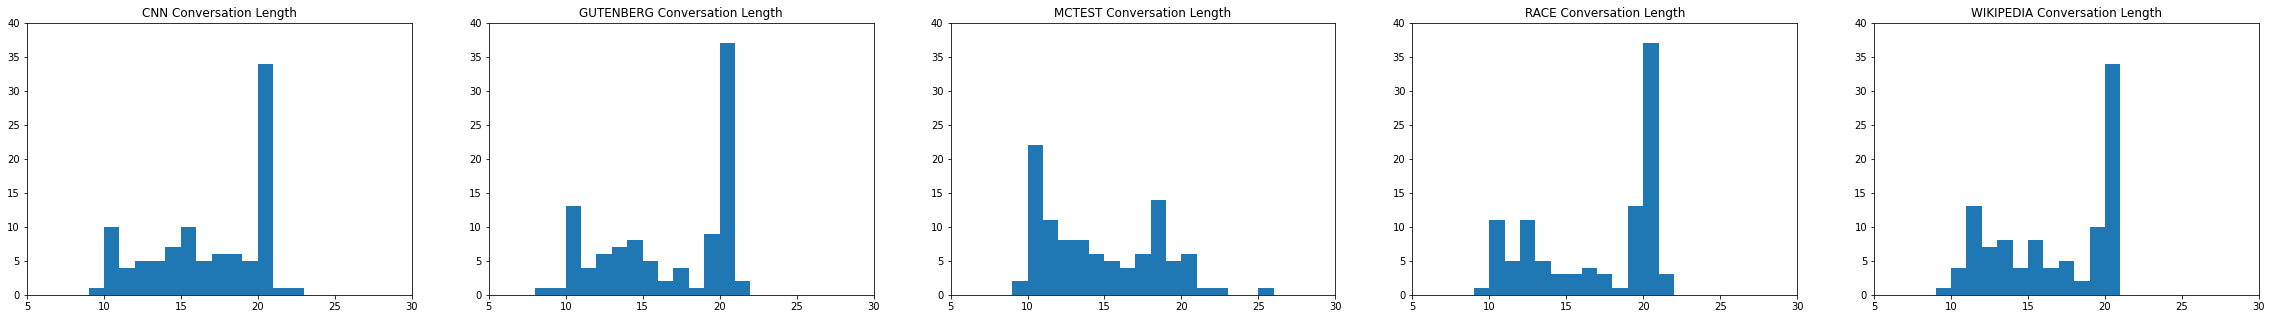

In [ ]:
plt.figure(figsize=(40,5))
i = 1
for source, df in grouped_df:
    plt.subplot(1, 5, i)
    plt.hist(df.loc[:, 'QA_length'], bins=range(5, 30, 1))
    plt.xlim((5, 30))
    plt.ylim((0, 40))
    plt.title(f"{source.upper()} Conversation Length")
    i += 1
plt.show()

In [ ]:
def test_conversation(models, df):
    """
    Inputs:
      - Trained Models
      - Dataframe containing dialogues

    Return:
      - Dataframe with f1 scores computed on dialogues
    """
    dialogues = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0], leave=False):
        passage   = row['story']
        questions = [q['input_text'] for q in row['questions']]
        answers   = [a['input_text'] for a in row['answers']]
        qa_pairs = list(zip(questions, answers))

        rationales = [a['rationale'] for a in row['answers']]
        indices = [(a['span_start'], a['span_end']) for a in row['answers']]
        
        dialogue_f1_scores = []  # f1-score of the whole dialogue
        answers_f1_scores = []   # f1-score of single answers within the dialogue
        preds = []; preds_tok_pos = []
        for model_name, (model, params) in models.items():
            model.eval()
            if params['history_length'] > 0 and params['history'] == True:
                dialogue_f1, (pred, f1_scores), (tok_pos, pred_tok_pos) = dialogue_with_history(model, passage, qa_pairs, indices, params['history_length'])
            else:
                dialogue_f1, (pred, f1_scores), (tok_pos, pred_tok_pos) = dialogue_without_history(model, passage, qa_pairs, indices)
            dialogue_f1_scores.append(dialogue_f1)
            answers_f1_scores.append(f1_scores)
            preds.append(pred)
            preds_tok_pos.append(pred_tok_pos)
      
        dialogue = {'source'       : row['source'],
                    'rationales'   : rationales, 
                    'questions'    : questions,
                    'answers'      : answers,
                    'preds'        : list(zip(*preds)),
                    'tok_pos'      : tok_pos,
                    'pred_tok_pos' : preds_tok_pos,
                    'answers_f1_scores' : answers_f1_scores,
                    'dialogue_f1_score' : np.mean(dialogue_f1_scores)}

        dialogues.append(dialogue)
    return pd.DataFrame(dialogues)


def source_eval(models_folder, model_type, with_history, df):
    """
    Inputs:
      - Folder containing the models
      - Model type ('bert' or 'roberta')
      - History selection (True or False)
      - DataFrame containing dialogues

    Returns:
      - Five worst dialogues
    """
    warnings.filterwarnings('ignore')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    models = {}
    for model_path in os.listdir(models_folder):
        seed = int(model_path.split('-')[-1])
        history_length = int(model_path.split('-')[-2])
        history = True if history_length > 0 else False

        if model_path.split('-')[0] != model_type or history != with_history:
            continue
        
        params = {'seed': seed, 'history_length': history_length, 'history': history}
        models.update({model_path: (torch.load(models_folder + model_path).to(device), params)})
    
    dialogues = test_conversation(models, df)
    dialogues = dialogues.sort_values(by='dialogue_f1_score', ascending=True, inplace=False).iloc[:5, :].reset_index(drop=True)    
    return dialogues


def print_worst_answers(dialogues):
    """
    Inputs:
      - Five worst dialogues

    Prints:
      - Worst answer for each dialogue (random tie breaking)
    """
    worst_answers_idx = [np.random.choice(np.flatnonzero(np.mean(row['answers_f1_scores'], axis=0) == np.mean(row['answers_f1_scores'], axis=0).min())) for _, row in dialogues.iterrows()]
    #worst_answers_idx = [np.argmin(np.mean(row['answers_f1_scores'], axis=0), axis=-1) for _, row in dialogues.iterrows()] # Tie -> first idx
    y_step = [0, 0, 1, 0]
    for idx, row in dialogues.iterrows():
        print(f"\n[SQUAD F1-score -> {np.mean([row['answers_f1_scores'][model][worst_answers_idx[idx]] for model in range(3)]):.4f}]")
        rationale = row['rationales'][worst_answers_idx[idx]]
        question  = row['questions'][worst_answers_idx[idx]]
        answer    = row['answers'][worst_answers_idx[idx]]
        preds     = row['preds'][worst_answers_idx[idx]]
        print('\nPassage    \t-> ', end='')
        print(rationale.replace('\n',  ' '))
        print('Question   \t-> ', end='')
        print(question)
        print('Answer     \t-> ', end='')
        print(answer)
        print('Predictions\t-> ', end='')
        print('1: ' + preds[0], end='     ')
        print('2: ' + preds[1], end='     ')
        print('3: ' + preds[2], end='\n\n')

        plt.figure(figsize=(10,1))
        plt.step(tuple2step(row['tok_pos'][worst_answers_idx[idx]]), y_step, c='black')
        plt.step(tuple2step(row['pred_tok_pos'][0][worst_answers_idx[idx]]), y_step, c='red', linestyle='dotted')
        plt.step(tuple2step(row['pred_tok_pos'][1][worst_answers_idx[idx]]), y_step, c='blue', linestyle='dotted')
        plt.step(tuple2step(row['pred_tok_pos'][2][worst_answers_idx[idx]]), y_step, c='lime', linestyle='dotted')
        plt.axis('off')
        plt.legend(["ground truth", "pred 1", "pred 2", "pred 3"], loc ="lower right")
        plt.title('Rationale Tokens')
        plt.show()
        print('\n')


def print_worst_dialogues(dialogues):
    """
    Inputs:
      - five worst dialogues

    Prints:
      - every answer for every dialogue
    """
    y_step = [0, 0, 1, 0]
    for idx, row in dialogues.iterrows():
        print('='*100)
        print('\nPASSAGE ' + str(idx) + '  [f1-score: ' + str(round(row['f1_score'], 4)) + ']', end='\n\n')
        turns = len(row['questions'])
        for t in range(turns):
            print(f'Turn {t}')
            print('Passage    \t-> ', end='')
            print(row['rationales'][t].replace('\n',  ' '))
            print('Question   \t-> ', end='')
            print(row['questions'][t])
            print('Answer     \t-> ', end='')
            print(row['answers'][t])
            print('Predictions\t-> ', end='')
            print('1: ' + row['preds'][t][0], end='     ')
            print('2: ' + row['preds'][t][1], end='     ')
            print('3: ' + row['preds'][t][2], end='\n\n')

            plt.figure(figsize=(10,1))
            plt.step(tuple2step(dialogues['tok_pos'][idx][t]), y_step, c='black')
            plt.step(tuple2step(dialogues['pred_tok_pos'][idx][0][t]), y_step, c='red', linestyle='dotted')
            plt.step(tuple2step(dialogues['pred_tok_pos'][idx][1][t]), y_step, c='blue', linestyle='dotted')
            plt.step(tuple2step(dialogues['pred_tok_pos'][idx][2][t]), y_step, c='lime', linestyle='dotted')
            plt.axis('off')
            plt.legend(["ground truth", "pred 1", "pred 2", "pred 3"], loc ="lower right")
            plt.title('Rationale Tokens')
            plt.show()
            print('\n\n')
        print('='*100)


def tuple2step(tok_pos):
    tok_pos = list(tok_pos)
    tok_pos.insert(0, 0)
    tok_pos.append(512)
    return tok_pos


def print_source_name(source_name, num_asterix=100):
    num_char = len(source_name)
    print('\n')
    print(f'#'*num_asterix)
    print('#'*(((num_asterix-2) - num_char)//2), end=' ')
    print(source_name.upper(), end=' ')
    print('#'*((num_asterix-2) - ((num_asterix-2) - num_char)//2 - num_char))
    print(f'#'*num_asterix, end='\n\n')

### BERTTiny - without history



####################################################################################################
############################################### CNN ################################################
####################################################################################################




[SQUAD F1-score -> 0.0000]

Passage    	-> Thirty-eight year old Mayweather (47-0, 26 knockouts), who favors the moniker "The Money Man" or "TBE" (The Best Ever), boasts nearly five million Instagram followers, 5.65 million followers on Twitter and 9.2 million Facebook likes. 
Question   	-> What is Mayweathers nick name?
Answer     	-> 1 is the money man
Predictions	-> 1: diego pacquiao     2: tom pacquiao     3: nick



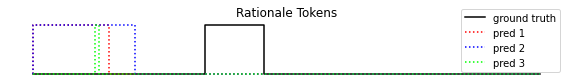




[SQUAD F1-score -> 0.0000]

Passage    	-> Redmond O'Neal was on a day pass away from the Pasadena, California, sober living facility where he is undergoing court-ordered drug rehab
Question   	-> Why is he there?
Answer     	-> he is undergoing court-ordered drug rehab
Predictions	-> 1: because they's here     2: his mother's death     3: he's so awesome



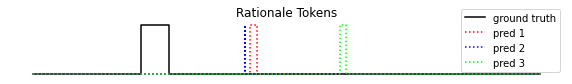




[SQUAD F1-score -> 0.0000]

Passage    	-> Der Spiegel identifies the soldiers as Spc. Jeremy Morlock 
Question   	-> What is the name of one of the soldiers?
Answer     	-> Jeremy Morlock
Predictions	-> 1: u. s. soldiers     2: the u. s. police department     3: the german news agency



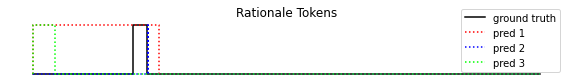




[SQUAD F1-score -> 0.0000]

Passage    	-> David Duerson shot himself in the chest
Question   	-> how did David die?
Answer     	-> shot himself in the chest
Predictions	-> 1: he's brain damage     2: his brain damage     3: 50



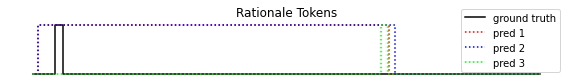




[SQUAD F1-score -> 0.0000]

Passage    	-> So you were born in Mexico but grew up in Kenya.  
Question   	-> Where was she raised?
Answer     	-> Kenya
Predictions	-> 1: the best supporting role in last year     2: california     3: ln



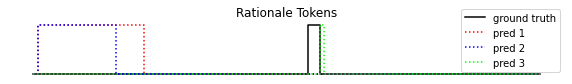





####################################################################################################
############################################ GUTENBERG #############################################
####################################################################################################




[SQUAD F1-score -> 0.0000]

Passage    	-> He was sure that Barbara had loved this man
Question   	-> why is that?
Answer     	-> Barbara had loved this man
Predictions	-> 1: to the little island     2: a letter     3: his rashed over again



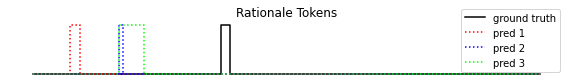




[SQUAD F1-score -> 0.0000]

Passage    	-> American recluse
Question   	-> What kind of person was Father Esteban?
Answer     	-> American recluse
Predictions	-> 1: aguil d. c.     2: a letter     3: monteban



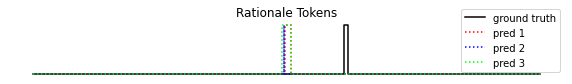




[SQUAD F1-score -> 0.0000]

Passage    	-> he might still win Miriam
Question   	-> And her name?
Answer     	-> Miriam
Predictions	-> 1: marcus     2: her mother     3: judgment



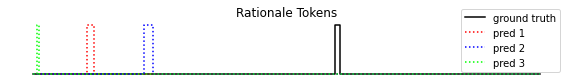




[SQUAD F1-score -> 0.0000]

Passage    	-> I move that we keep our eyes open for some place where we can take it easy and have lunch
Question   	-> What did Andy want them to watch for?
Answer     	-> a place to take it easy and have lunch
Predictions	-> 1: his watch.     2: on horseback     3: yes



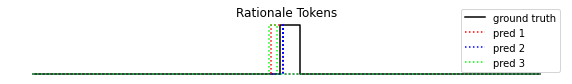




[SQUAD F1-score -> 0.0000]

Passage    	-> the Excommunication, for some weeks arrived from Rome, was solemnly published in the Duomo
Question   	-> Where was the Excommunication published?
Answer     	-> in the Duomo
Predictions	-> 1: the new life of savona     2: new york     3: rome



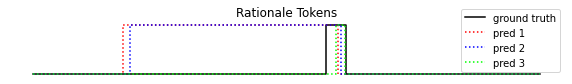





####################################################################################################
############################################## MCTEST ##############################################
####################################################################################################




[SQUAD F1-score -> 0.0000]

Passage    	-> paid well, both in potatoes, carrots and money
Question   	-> How much money do they get paid?
Answer     	-> paid well
Predictions	-> 1: millions     2: two     3: potatoes



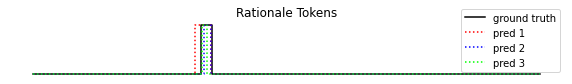




[SQUAD F1-score -> 0.0000]

Passage    	-> They then took a boat to Africa and Asia
Question   	-> where'd they go next?
Answer     	-> Africa
Predictions	-> 1: the mountains.     2: south america     3: the mountains



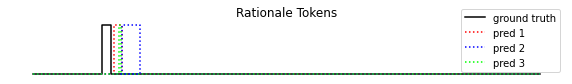




[SQUAD F1-score -> 0.0000]

Passage    	->  His mom had packed them a lunch
Question   	-> What did his mom do?
Answer     	-> Packed them a lunch
Predictions	-> 1: he sent peanut butter     2: ate peanut butter and jelly sandwiches     3: put his mom



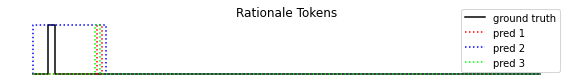




[SQUAD F1-score -> 0.0000]

Passage    	-> Knights can't fly! 
Question   	-> Who thinks they can't?
Answer     	-> bobby
Predictions	-> 1: the other people who can't know.     2: i't fair! you can't fly!     3: jack



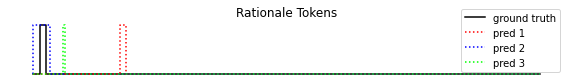




[SQUAD F1-score -> 0.0000]

Passage    	-> She named her new noodle friend Joey
Question   	-> Who named him?
Answer     	-> Marsha
Predictions	-> 1: joey     2: her brother     3: her new no



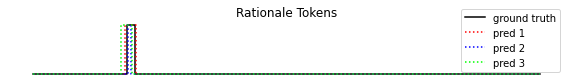





####################################################################################################
############################################### RACE ###############################################
####################################################################################################




[SQUAD F1-score -> 0.0000]

Passage    	-> Kody, was diagnosed with type diabetes at six
Question   	-> How old was Kody when he was diagnosed with diabetes?
Answer     	-> six
Predictions	-> 1: 27     2: 1, 100     3: 28



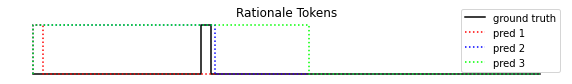




[SQUAD F1-score -> 0.0000]

Passage    	-> literature
Question   	-> And?
Answer     	-> literature
Predictions	-> 1: yes     2: yes     3: yes



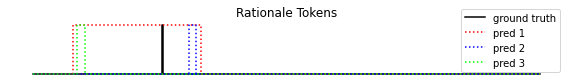




[SQUAD F1-score -> 0.0000]

Passage    	->  you will unconsciously form a triangle
Question   	-> What about three folks?
Answer     	-> you will unconsciously form a triangle
Predictions	-> 1: about an arm's width     2: two     3: an arm's length



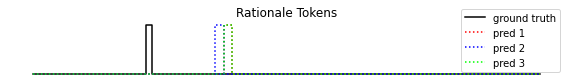




[SQUAD F1-score -> 0.0000]

Passage    	-> Shirley Temple Black
Question   	-> Who is this news story about?
Answer     	-> Shirley Temple Black
Predictions	-> 1: a great man     2: a great storm     3: a great



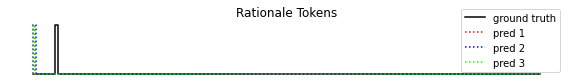




[SQUAD F1-score -> 0.0000]

Passage    	-> Helen began to search for Ed's car
Question   	-> What are the names of the couple?
Answer     	-> Helen and Ed
Predictions	-> 1: lady talking on the phone     2: her husband     3: her doctor's



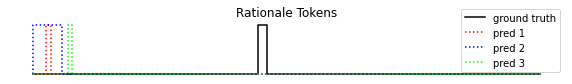





####################################################################################################
############################################ WIKIPEDIA #############################################
####################################################################################################




[SQUAD F1-score -> 0.0000]

Passage    	->  This is triggered by the pituitary gland, which secretes a surge of hormonal agents into the blood stream, initiating a chain reaction to occur
Question   	-> What alters those?
Answer     	-> hormonal agents
Predictions	-> 1: biology     2: science and economics.     3: a strong range



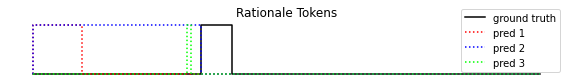




[SQUAD F1-score -> 0.0000]

Passage    	-> itation needed
Question   	-> Was there a citation for this?
Answer     	-> citation needed
Predictions	-> 1: yes     2: yes     3: yes



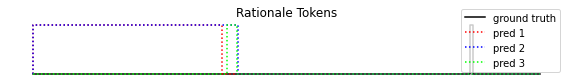




[SQUAD F1-score -> 0.0000]

Passage    	-> While the MC controls resources and signaling negotiations, the MP operates on the media plane and receives media from each endpoint
Question   	-> Does something work on the media plane?
Answer     	-> the MP
Predictions	-> 1: yes     2: yes     3: yes



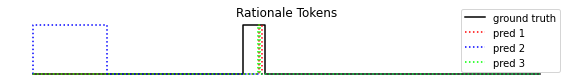




[SQUAD F1-score -> 0.0000]

Passage    	-> that encircles a lagoon
Question   	-> what is another attribute?
Answer     	-> it encircles a lagoon
Predictions	-> 1: coral reefs     2: a reef     3: a reef



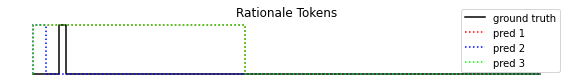




[SQUAD F1-score -> 0.0000]

Passage    	-> that the A above middle C be tuned to 440 Hz.
Question   	-> What did they recommend?
Answer     	-> that the A above middle C be tuned to 440 Hz.
Predictions	-> 1: a locomotive machine     2: the united states and other musical instruments.     3: johann schommer



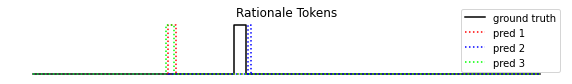

In [ ]:
models_folder = 'Models/'
model_type = 'bert'
with_history = False

for source, source_df in grouped_df:
    print_source_name(source)

    dialogues = source_eval(models_folder, model_type, with_history, source_df)   # Extract 5 worst dialogues 
    print_worst_answers(dialogues)                                                # Print worst answer for each dialogue (random tie breaking)

As we can see from the examples above ...

### BERTTiny - with history



####################################################################################################
############################################### CNN ################################################
####################################################################################################




[SQUAD F1-score -> 0.0000]

Passage    	->  Kenyan actress Lupita Nyong'o has become a new critics' darling after her breakout role in last year's hit movie "12 Years A Slave."  
Question   	-> What movie was her breakout role in?
Answer     	-> "12 Years A Slave.
Predictions	-> 1: rien'o     2: cnn     3: kenyan actress lupita ny



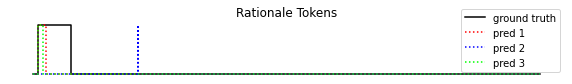




[SQUAD F1-score -> 0.0000]

Passage    	-> successfully
Question   	-> did it fail ?
Answer     	-> no
Predictions	-> 1: yes     2: yes     3: yes



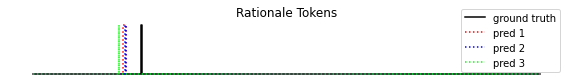




[SQUAD F1-score -> 0.0000]

Passage    	-> Two images show the soldiers kneeling by a bloody body sprawled over a patch of sand and grass
Question   	-> What was the condition of the body?
Answer     	-> bloody
Predictions	-> 1: u. s. navy     2: u. s. soldiers     3: world der spiegel has published photographs of what would be two u. s. soldiers in



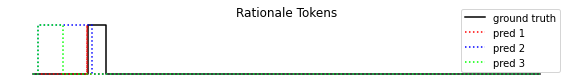




[SQUAD F1-score -> 0.0000]

Passage    	-> Bae, a Korean-American
Question   	-> Where was he from?
Answer     	-> Korean-American
Predictions	-> 1: u. s. senator     2: the u. s. attorney general     3: labor camp.



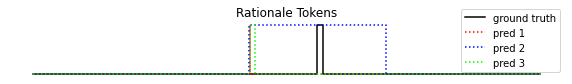




[SQUAD F1-score -> 0.0000]

Passage    	-> Republican Ken Cuccinelli will be delivering a concession speech on Tuesday evening in Richmond.
Question   	-> Where will he give the speech if he makes it?
Answer     	-> Richmond.
Predictions	-> 1: a - year bar     2: new york     3: on - year barometric of national political action



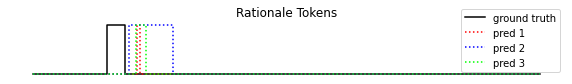





####################################################################################################
############################################ GUTENBERG #############################################
####################################################################################################




[SQUAD F1-score -> 0.0000]

Passage    	-> He might dog Marcus
Question   	-> Against who?
Answer     	-> Marcus
Predictions	-> 1: his heart,     2: yes     3: his heart



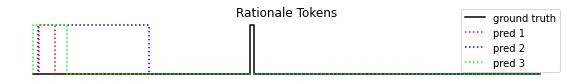




[SQUAD F1-score -> 0.0000]

Passage    	->  and all united in declaring that "Josh was a right good fellow."  
Question   	-> what did all unite in calling josh?
Answer     	-> A right good fellow.
Predictions	-> 1: he had expected that his friends     2: he could be able to secure a pace with him.     3: the applause of all present



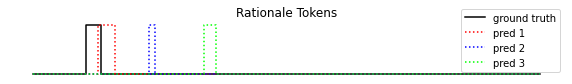




[SQUAD F1-score -> 0.0000]

Passage    	-> Father Esteban received her with a coldness 
Question   	-> How was she received?
Answer     	-> with a coldness
Predictions	-> 1: half - hour     2: he was more disturbed and excited     3: it was put in the plaza



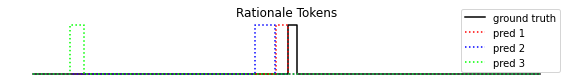




[SQUAD F1-score -> 0.0000]

Passage    	-> breaking down of one or other of the beasts, or by stress of weather.
Question   	-> And why is it that they were compelled to stay in those inn?
Answer     	-> breaking down  of the beasts
Predictions	-> 1: they were compelled to stay in those inns,     2: he was unable to move on his forehead     3: to stay in those inns



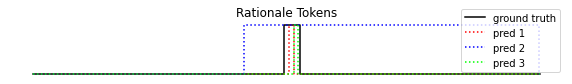




[SQUAD F1-score -> 0.0000]

Passage    	-> So whilst me and Jim filed away at the pens on a brickbat apiece, 
Question   	-> on what?
Answer     	-> on a brickbat
Predictions	-> 1: his coat o'clock     2: ran away     3: jim



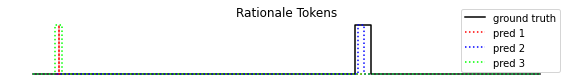





####################################################################################################
############################################## MCTEST ##############################################
####################################################################################################




[SQUAD F1-score -> 0.0000]

Passage    	-> traveled by plane around Europe
Question   	-> how'd they get there?
Answer     	-> by plane
Predictions	-> 1: one day     2: two days     3: they went on a trip through the mountains.



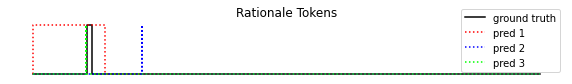




[SQUAD F1-score -> 0.0000]

Passage    	-> on Saturday morning.
Question   	-> When did they go to visit their Aunt?
Answer     	-> Saturday morning
Predictions	-> 1: when he went to their auntie's     2: 2007     3: his auntie's house to visit on



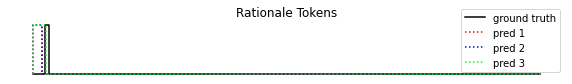




[SQUAD F1-score -> 0.0000]

Passage    	-> Aiming the football at the tire swing
Question   	-> What was he throwing the ball at?
Answer     	-> a tire swing
Predictions	-> 1: a ball     2: a white lace     3: a ball



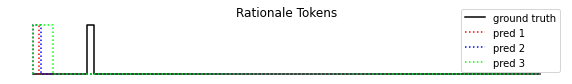




[SQUAD F1-score -> 0.0000]

Passage    	-> Mother's Day
Question   	-> What holiday was coming up?
Answer     	-> Mother's Day
Predictions	-> 1: max     2: her little brother     3: her little brother



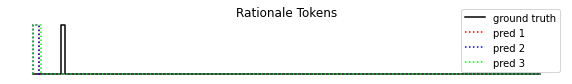




[SQUAD F1-score -> 0.0000]

Passage    	->  take pictures with their phones
Question   	-> what else do they do with the phones?
Answer     	-> Take pictures.
Predictions	-> 1: play in the woods     2: went through the woods     3: they went out to play in the woods.



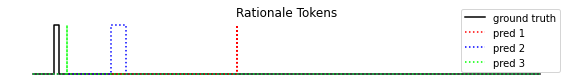





####################################################################################################
############################################### RACE ###############################################
####################################################################################################




[SQUAD F1-score -> 0.0000]

Passage    	-> "Everyone should just relax", say linguists . They believe Netspeak is in fact more of a good thing.
Question   	-> who thinks netspeak may not be a bad thing?
Answer     	-> linguists
Predictions	-> 1: geoffrey nurberg     2: stanford university     3: more than their parents.



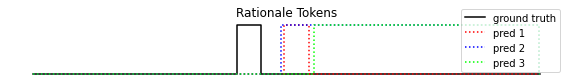




[SQUAD F1-score -> 0.0000]

Passage    	-> He left Canton, Michigan for New York, got a job waiting tables, nicknamed himself the Diabetic Rockstar , and created diabeticrockstar.com, a free online community for diabetic
Question   	-> What website did Christopher start?
Answer     	-> diabeticrockstar.com
Predictions	-> 1: a day for the rest of his life or risk     2: $ 1, 100 million     3: a new york



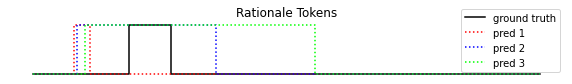




[SQUAD F1-score -> 0.0000]

Passage    	->  We created a charging station, outside her bedroom,
Question   	-> What did they make outside of her room?
Answer     	-> A charging station.
Predictions	-> 1: her 12 - year - old daughter     2: a phone     3: she could use the device for school.



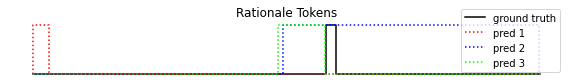




[SQUAD F1-score -> 0.0000]

Passage    	-> "I've felt sick since then," Luxmoore told reporters
Question   	-> What did he tell the reporters?
Answer     	-> "I've felt sick since then."
Predictions	-> 1: the library company     2: he had received a letter     3: yes



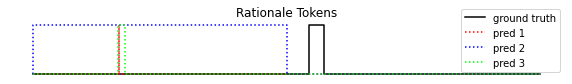




[SQUAD F1-score -> 0.0000]

Passage    	-> By 1940, she had appeared in 43 films.
Question   	-> How old was she when she started acting?
Answer     	-> Four.
Predictions	-> 1: 49     2: 16     3: 16



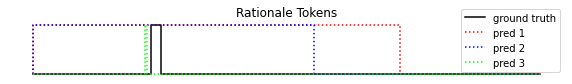





####################################################################################################
############################################ WIKIPEDIA #############################################
####################################################################################################




[SQUAD F1-score -> 0.0000]

Passage    	-> Some boys may develop gynecomastia due to an imbalance of sex hormones, tissue responsiveness or obesity.
Question   	-> What can happen if the balance of those agents change too much?
Answer     	-> gynecomastia
Predictions	-> 1: a surge of rapid growth.     2: a state     3: a state of rapid growth



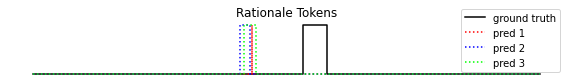




[SQUAD F1-score -> 0.0000]

Passage    	-> The British Colonial Office appointed five Aboriginal Protectors
Question   	-> What was done to help them?
Answer     	-> The British Colonial Office appointed five Aboriginal Protectors
Predictions	-> 1: the port of melbourne airport     2: the port of melbourne airport     3: new cross station.



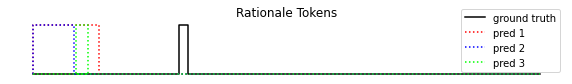




[SQUAD F1-score -> 0.0000]

Passage    	-> The stated clauses of the Nazi-Soviet non-aggression pact were a guarantee of non-belligerence by each party towards the other, and a written commitment that neither party would ally itself to, or aid, an enemy of the other party. 
Question   	-> What was the goal of the Nazi-Soviet pact?
Answer     	-> guarantee of non-belligerence by each party
Predictions	-> 1: the nazi - soviet union     2: czechoslovakia     3: soviet sphere



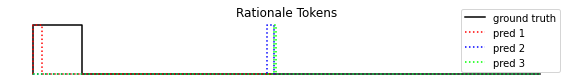




[SQUAD F1-score -> 0.0000]

Passage    	-> professor of botany at the University of Hamburg,
Question   	-> Where?
Answer     	-> University of Hamburg,
Predictions	-> 1: in 1920     2: london     3: in biology and biology



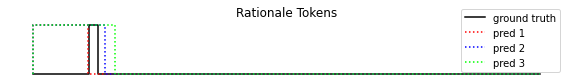




[SQUAD F1-score -> 0.0000]

Passage    	-> that encircles a lagoon
Question   	-> what is another attribute?
Answer     	-> it encircles a lagoon
Predictions	-> 1: a reef     2: an island     3: the pacific ocean



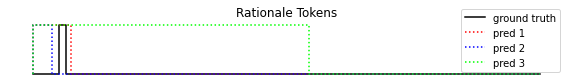

In [ ]:
models_folder = 'Models/'
model_type = 'bert'
with_history = True

for source, source_df in grouped_df:
    print_source_name(source)

    dialogues = source_eval(models_folder, model_type, with_history, source_df)   # Extract 5 worst dialogues 
    print_worst_answers(dialogues)                                                # Print worst answer for each dialogue (random tie breaking)

As we can see from the examples above ...

### DistilRoBERTA - without history



####################################################################################################
############################################### CNN ################################################
####################################################################################################




[SQUAD F1-score -> 0.0000]

Passage    	-> He preferred telling his fans directly, from the comfort of home, 
Question   	-> From where he posted that message?
Answer     	-> home
Predictions	-> 1: YouTube     2: YouTube     3: YouTube



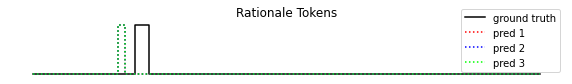




[SQUAD F1-score -> 0.0000]

Passage    	-> Democrat Terry McAuliffe, the longtime political fixer and moneyman, hasn't trailed in a poll since May. Barring a political miracle, Republican Ken Cuccinelli will be delivering a concession speech
Question   	-> Which of them is winning?
Answer     	-> Democrat Terry McAuliffe
Predictions	-> 1: Bob McDonnell     2: Bob McDonnell     3: Bob McDonnell



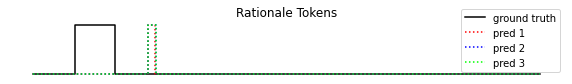




[SQUAD F1-score -> 0.0000]

Passage    	-> Aazis Richardson is accused of shooting the cab driver, Vincent Darbenzio
Question   	-> WHO DID HE SHOOT?
Answer     	-> Vincent Darbenzio
Predictions	-> 1: Aazis Richardson     2: Aazis     3: West and 3-year-related



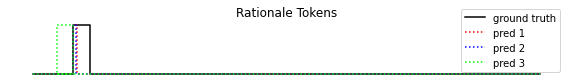




[SQUAD F1-score -> 0.0000]

Passage    	-> Following the lead of Asian-American activist Suey Park, some have been demanding that "The Colbert Report" be canceled.
Question   	-> does he have a show?
Answer     	-> "The Colbert Report"
Predictions	-> 1: no     2: yes     3: yes



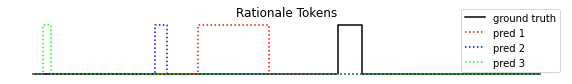




[SQUAD F1-score -> 0.0000]

Passage    	-> e hospital's associate director, Dr. Carl Schulma
Question   	-> What is his name?
Answer     	-> Dr. Carl Schulman
Predictions	-> 1: Eerie Brewer, Sr.     2: A group of teenagers     3: Michael Brewer



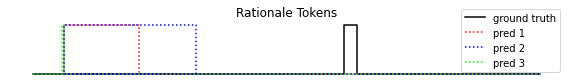





####################################################################################################
############################################ GUTENBERG #############################################
####################################################################################################




[SQUAD F1-score -> 0.0000]

Passage    	-> he might still win Miriam
Question   	-> And her name?
Answer     	-> Miriam
Predictions	-> 1: Domitian     2: Caleb     3: Helen-Maiden



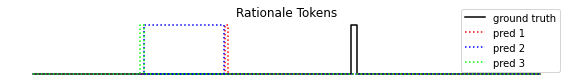




[SQUAD F1-score -> 0.0000]

Passage    	-> study her laws and customs
Question   	-> how did he attempt this?
Answer     	-> study her laws and customs
Predictions	-> 1: in his conspiracy     2: he had tried to enlist Comyn in his conspiracy     3: he had tried to enlist Comyn in his conspiracy



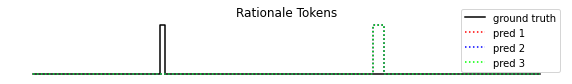




[SQUAD F1-score -> 0.0000]

Passage    	-> Miss Harding
Question   	-> and what is his daughter's name?
Answer     	-> Miss Harding
Predictions	-> 1: Barbara     2: Barbara     3:  Mallory



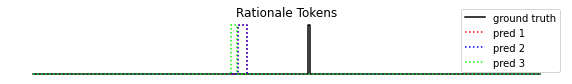




[SQUAD F1-score -> 0.0000]

Passage    	-> They screamed when they saw the natives about to murder those who were with
Question   	-> Who posed a danger to those people?
Answer     	-> The natives
Predictions	-> 1: Bathurst and her daughter     2: Isobel     3: Bathurst



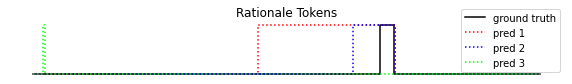




[SQUAD F1-score -> 0.0000]

Passage    	-> Bryan cast a comical leer at La Roche as he said this, and the poor Frenchman blushed
Question   	-> Who is there from France?
Answer     	-> La Roche
Predictions	-> 1: the young Frenchman     2: French Frenchman     3: France



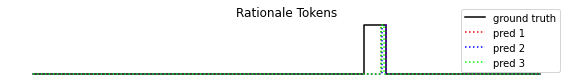





####################################################################################################
############################################## MCTEST ##############################################
####################################################################################################




[SQUAD F1-score -> 0.0000]

Passage    	-> she met her noodle friend was spaghetti nigh
Question   	-> Why did she make him?
Answer     	-> It was spaghetti night.
Predictions	-> 1: to make sure her mom     2: she loved him     3: to make sure Joey is safe and sound at all times



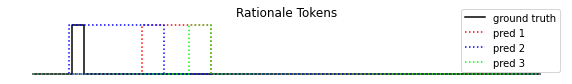




[SQUAD F1-score -> 0.0000]

Passage    	-> lick him in the face
Question   	-> What did the mother make him do?
Answer     	-> lick Douglas
Predictions	-> 1: went him to go to bed     2: get him in the face     3: kicked him in the face



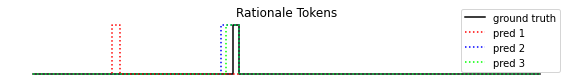




[SQUAD F1-score -> 0.0000]

Passage    	-> "Er, what's up?" I asked. 
Question   	-> What did you do?
Answer     	-> asked him what's up
Predictions	-> 1: ran out the door     2: watched     3: He ran out the door



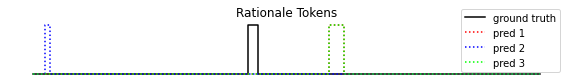




[SQUAD F1-score -> 0.0000]

Passage    	-> a witch
Question   	-> Who is the villain?
Answer     	-> a witch
Predictions	-> 1: Ellcessen     2: Ellen     3: PrincessEllie



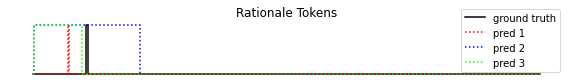




[SQUAD F1-score -> 0.0000]

Passage    	-> "Hello," one of the men said. "It is such a great night for walking." 
Question   	-> did they say anything?
Answer     	-> hello and it was a great night for walking
Predictions	-> 1: yes     2: no     3: Yes



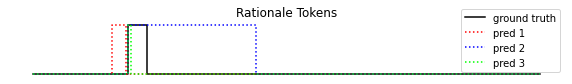





####################################################################################################
############################################### RACE ###############################################
####################################################################################################



 18%|█▊        | 18/100 [02:41<10:07,  7.40s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
                                                 


[SQUAD F1-score -> 0.0000]

Passage    	-> True, I was near nineteen
Question   	-> How old was this teacher?
Answer     	-> near nineteen
Predictions	-> 1: 19     2: twenty     3: nine



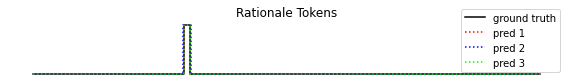




[SQUAD F1-score -> 0.0000]

Passage    	-> a sense of disempowerment
Question   	-> Do you feel empowered?
Answer     	-> a sense of disempowerment
Predictions	-> 1: yes     2: no     3: No



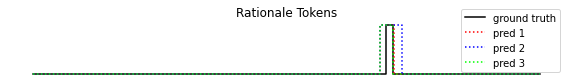




[SQUAD F1-score -> 0.0000]

Passage    	-> so that they may unlock the doors of knowledge
Question   	-> For what?
Answer     	-> so that they may unlock the doors of knowledge
Predictions	-> 1: to stop the gates.     2: for those who are well-directed     3: to rest and recreation



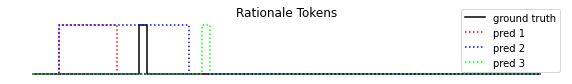




[SQUAD F1-score -> 0.0000]

Passage    	-> without eating
Question   	-> How do they stay out so long?
Answer     	-> without eating
Predictions	-> 1: the walking catfish     2: for hours at a time     3: The walking catfish found in Southeast Asia can stay on land for a time at a time



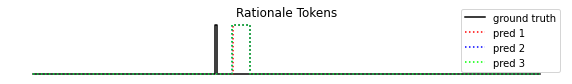




[SQUAD F1-score -> 0.0000]

Passage    	-> a farmer died
Question   	-> Why only four days?
Answer     	-> a farmer died
Predictions	-> 1: He returned home     2: he was different from the seaside     3: he returned home.



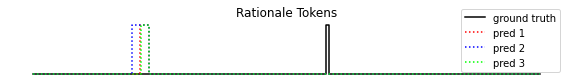





####################################################################################################
############################################ WIKIPEDIA #############################################
####################################################################################################



 93%|█████████▎| 93/100 [15:17<01:06,  9.49s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors
                                                 


[SQUAD F1-score -> 0.0000]

Passage    	-> Within all of these perspectives, adolescence is viewed as a transitional period between childhood and adulthood, whose cultural purpose is the preparation of children for adult roles. 
Question   	-> What non-biological purpose does it have?
Answer     	-> cultural
Predictions	-> 1: the preparation of children for adult roles     2: preparing children foradult roles.     3: preparing of children for adult roles



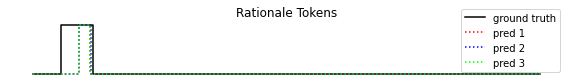




[SQUAD F1-score -> 0.0000]

Passage    	-> itation needed
Question   	-> Was there a citation for this?
Answer     	-> citation needed
Predictions	-> 1: yes     2: yes     3: yes



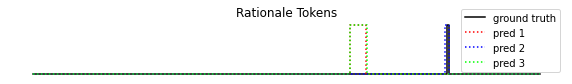




[SQUAD F1-score -> 0.0000]

Passage    	-> favors direct understanding through zazen and interaction with an accomplished teacher.
Question   	-> What does it value instead?
Answer     	-> Direct understanding
Predictions	-> 1: less knowledge of sutras and doctrine     2: they de-emphasize through zutras and interaction with an accomplished teacher     3: class of sutras and interaction with an accomplished teacher.



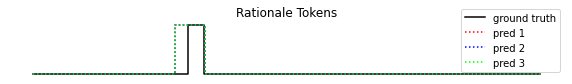




[SQUAD F1-score -> 0.0000]

Passage    	->  about 750 Jews
Question   	-> how many are there?
Answer     	-> about 750 Jews
Predictions	-> 1: a few thousand     2: a few thousand     3: 1.0%



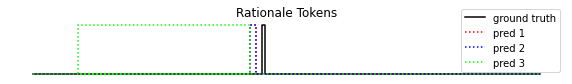




[SQUAD F1-score -> 0.0000]

Passage    	->  the torch traveled to the Panathinaiko Stadium in Athens
Question   	-> Did they visit any notable landmarks?
Answer     	-> Panathinaiko Stadium
Predictions	-> 1: yes     2: yes     3: yes



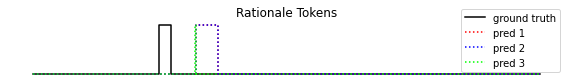

In [ ]:
models_folder = 'Models/'
model_type = 'roberta'
with_history = False

for source, source_df in grouped_df:
    print_source_name(source)

    dialogues = source_eval(models_folder, model_type, with_history, source_df)   # Extract 5 worst dialogues 
    print_worst_answers(dialogues)                                                # Print worst answer for each dialogue (random tie breaking)

As we can see from the examples above ...

### DistilRoBERTA - with history



####################################################################################################
############################################### CNN ################################################
####################################################################################################




[SQUAD F1-score -> 0.0000]

Passage    	-> Aazis Richardson is accused of shooting the cab driver
Question   	-> WHAT DID HE DO FOR A LIVING
Answer     	-> cab driver
Predictions	-> 1: he was accused     2: taking a longer route to his destination.     3: shot him



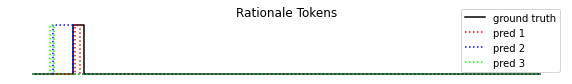




[SQUAD F1-score -> 0.0000]

Passage    	-> CTE has been found in the brains of 14 of 15 former NFL players thus far studied at the center.
Question   	-> how many players has the centers studied?
Answer     	-> 15
Predictions	-> 1: 14     2: 14.     3: 14



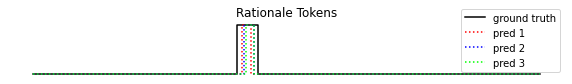




[SQUAD F1-score -> 0.0000]

Passage    	-> Herdon went first,
Question   	-> Who went first about it?
Answer     	-> Herdo
Predictions	-> 1: People Magazine and Entertainment     2: Don.     3: People Magazine



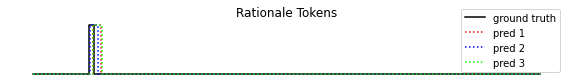




[SQUAD F1-score -> 0.0000]

Passage    	-> where Lewis Hamilton and his mighty Mercedes dominate
Question   	-> Who prevailed when he wasn't able to attend finally?
Answer     	-> Lewis Hamilton
Predictions	-> 1: DaneKevin Magnussen     2: Fernando Alonso     3: Dane Kevin Magn



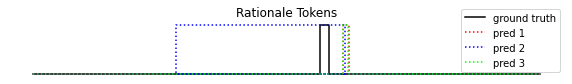




[SQUAD F1-score -> 0.0000]

Passage    	-> Following the lead of Asian-American activist Suey Park, some have been demanding that "The Colbert Report" be canceled.
Question   	-> does he have a show?
Answer     	-> "The Colbert Report"
Predictions	-> 1: Yes     2: Yes.     3: yes



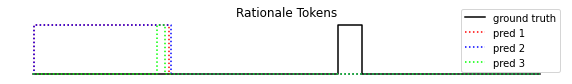





####################################################################################################
############################################ GUTENBERG #############################################
####################################################################################################




[SQUAD F1-score -> 0.0000]

Passage    	-> he might still win Miriam
Question   	-> And her name?
Answer     	-> Miriam
Predictions	-> 1: Domitian.     2: Pearl-Maiden     3: Har Pearl-Maiden



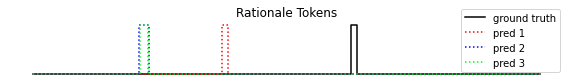




[SQUAD F1-score -> 0.0000]

Passage    	-> the main saloon
Question   	-> Where did he decide to go?
Answer     	-> the main saloon
Predictions	-> 1: to bed     2: the country     3: the country



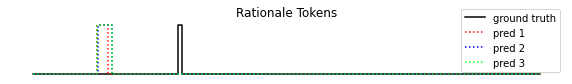




[SQUAD F1-score -> 0.0000]

Passage    	-> know something of Captain Grady
Question   	-> Why?
Answer     	-> he knew Captain Grady
Predictions	-> 1: the words of the words     2: to do something of the horse thieves' gang     3: because Paul and ChetWinthrop were deeply interested.



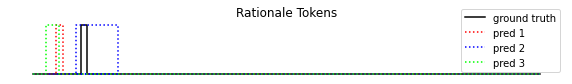




[SQUAD F1-score -> 0.0000]

Passage    	-> Lady Ashleigh sighed. 
Question   	-> Who is the mother?
Answer     	-> Lady Ashleigh
Predictions	-> 1: Ella     2: Ella     3: Ella



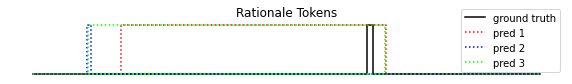




[SQUAD F1-score -> 0.0000]

Passage    	-> the hermit
Question   	-> Who answered him?
Answer     	-> the hermit
Predictions	-> 1: the hermitagg     2: Tom     3: the mother



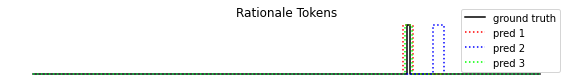





####################################################################################################
############################################## MCTEST ##############################################
####################################################################################################




[SQUAD F1-score -> 0.0000]

Passage    	->  Ruffles the dog started barking and then licking Douglas in the face
Question   	-> Did he do the same thing to wake him up another time?
Answer     	-> yes
Predictions	-> 1: no     2: No     3: no



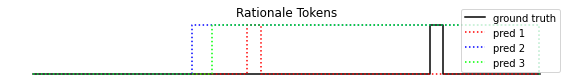




[SQUAD F1-score -> 0.0000]

Passage    	-> But today there were only a few flamingos
Question   	-> Did he see anything?
Answer     	-> flamingos
Predictions	-> 1: Yes     2: Yes     3: yes



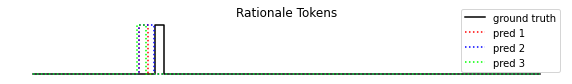




[SQUAD F1-score -> 0.0000]

Passage    	-> Sometimes Joey gets a little dried out so Marsha's mom told her to soak him in water every few days. 
Question   	-> Does he stay fresh?
Answer     	-> Yes.
Predictions	-> 1: no     2: no     3: no



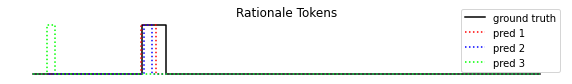




[SQUAD F1-score -> 0.0000]

Passage    	-> Next they took another plane to Australia
Question   	-> then where?
Answer     	-> Australia
Predictions	-> 1: through the mountains     2: Africa     3: in the month



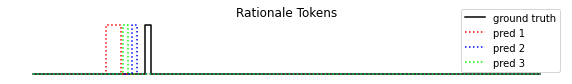




[SQUAD F1-score -> 0.0000]

Passage    	->  but fixing the window was very hard. 
Question   	-> what was difficult to repair?
Answer     	-> The window.
Predictions	-> 1: the toilet     2: Some things around the farm.     3: her hands



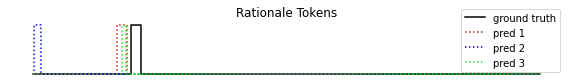





####################################################################################################
############################################### RACE ###############################################
####################################################################################################



 18%|█▊        | 18/100 [02:42<10:07,  7.41s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
                                                 


[SQUAD F1-score -> 0.0000]

Passage    	-> he remaining one was Harriet, a little broad, fat, merry, playful thing of scarcely two,
Question   	-> Does the story tell you who the youngest was?
Answer     	-> Yes
Predictions	-> 1: no     2: no     3: no



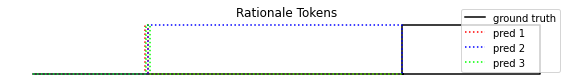




[SQUAD F1-score -> 0.0000]

Passage    	-> Babette Renneberg
Question   	-> According to whom?
Answer     	-> Babette Renneberg
Predictions	-> 1: a little anxious     2: Nick White     3: the back of our mind



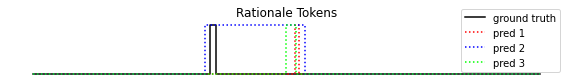




[SQUAD F1-score -> 0.0000]

Passage    	-> $35
Question   	-> What is the price of that course?
Answer     	-> $35
Predictions	-> 1: $75     2: $25     3: $75.



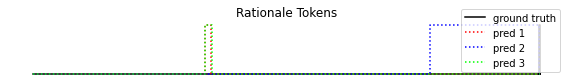




[SQUAD F1-score -> 0.0000]

Passage    	-> tended sheep
Question   	-> What was he doing on side of a hill?
Answer     	-> tended sheep
Predictions	-> 1: thrying for the hillside     2: Playing on the hill.     3: he was in the hillside



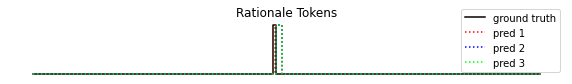




[SQUAD F1-score -> 0.0000]

Passage    	->  a 120-page diary kept 190 years ago by Deborah Logan
Question   	-> Whose diary was it?
Answer     	-> Deborah Logan's
Predictions	-> 1: John     2: Giles     3: Debothy Logan



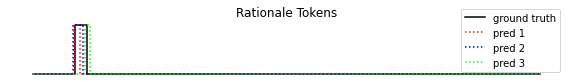





####################################################################################################
############################################ WIKIPEDIA #############################################
####################################################################################################



 93%|█████████▎| 93/100 [15:02<01:05,  9.42s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors
                                                 


[SQUAD F1-score -> 0.0000]

Passage    	-> . The male and female gonads are subsequently activated,
Question   	-> What does the pituitary gland alter?
Answer     	-> the male and female gonads
Predictions	-> 1: no     2: a surge of hormonal agents     3: the pituitary glands



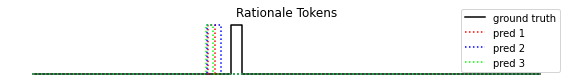




[SQUAD F1-score -> 0.0000]

Passage    	-> Weinreich and Saunderson
Question   	-> Who collaborated with him?
Answer     	-> Saunderson
Predictions	-> 1: scientiologists and Anthropologist     2: Erikson     3: Andy, Erikson, and others



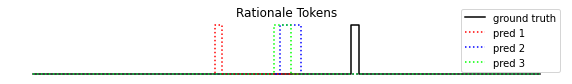




[SQUAD F1-score -> 0.0000]

Passage    	->  Japan, where it became known as Japanese Zen
Question   	-> What is it called in Japan?
Answer     	-> Japanese Zen
Predictions	-> 1: Japan     2:  Chan Buddhism     3: Japan



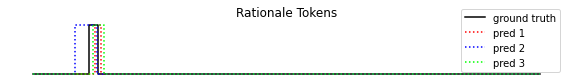




[SQUAD F1-score -> 0.0000]

Passage    	-> There are only a few thousand Muslims (largely migrants) and about 750 Jews
Question   	-> what other ethnic groups are there in this area?
Answer     	-> Muslims, Jews
Predictions	-> 1: the United States     2: Non-religious or adhere to other faiths     3: other Orthodox or adhere to other faiths.



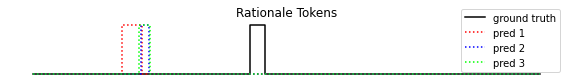




[SQUAD F1-score -> 0.0000]

Passage    	-> Greece is a developed country
Question   	-> Is Greece a developing country?
Answer     	-> no
Predictions	-> 1: yes     2: Yes     3: yes



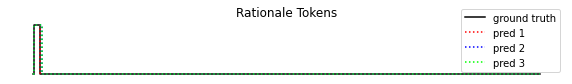

In [ ]:
models_folder = 'Models/'
model_type = 'roberta'
with_history = True

for source, source_df in grouped_df:
    print_source_name(source)

    dialogues = source_eval(models_folder, model_type, with_history, source_df)   # Extract 5 worst dialogues 
    print_worst_answers(dialogues)                                                # Print worst answer for each dialogue (random tie breaking)

As we can see from the examples above ...

# Assignment Evaluation

The following assignment points will be awarded for each task as follows:

* Task 1, Pre-processing $\rightarrow$ 0.5 points.
* Task 2, Dataset Splitting $\rightarrow$ 0.5 points.
* Task 3 and 4, Models Definition $\rightarrow$ 1.0 points.
* Task 5 and 6, Models Training and Evaluation $\rightarrow$ 2.0 points.
* Task 7, Analysis $\rightarrow$ 1.0 points.
* Report $\rightarrow$ 1.0 points.

**Total** = 6 points <br>

We may award an additional 0.5 points for outstanding submissions. 
 
**Speed Bonus** = 0.5 extra points <br>

# Report

We apply the rules described in Assignment 1 regarding the report.
* Write a clear and concise report following the given overleaf template (**max 2 pages**).
* Report validation and test results in a table.$^1$
* **Avoid reporting** code snippets or copy-paste terminal outputs $\rightarrow$ **Provide a clean schema** of what you want to show

# Comments and Organization

Remember to properly comment your code (it is not necessary to comment each single line) and don't forget to describe your work!

Structure your code for readability and maintenance. If you work with Colab, use sections. 

This allows you to build clean and modular code, as well as easy to read and to debug (notebooks can be quite tricky time to time).

# FAQ (READ THIS!)

---

**Question**: Does Task 3 also include data tokenization and conversion step?

**Answer:** Yes! These steps are usually straightforward since ```transformers``` also offers a specific tokenizer for each model.

**Example**: 

```
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
encoded_text = tokenizer(text)
%% Alternatively
inputs = tokenizer.tokenize(text, add_special_tokens=True, max_length=min(max_length, 512))
input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
```

**Suggestion**: Hugginface's documentation is full of tutorials and user-friendly APIs.

---
---

**Question**: I'm hitting **out of memory error** when training my models, do you have any suggestions?

**Answer**: Here are some common workarounds:

1. Try decreasing the mini-batch size
2. Try applying a different padding strategy (if you are applying padding): e.g. use quantiles instead of maximum sequence length

---
---

# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Andrea Galassi -> a.galassi@unibo.it
* Federico Ruggeri -> federico.ruggeri6@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# The End!

Questions?